<h1>To run this notebook:</h1>
<h4>Please install all the packages in the cell below and clone the repository :
https://github.com/Las02/GOT_social_graph/
There are some data files that are needed to run the notebook
</h4>

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import powerlaw
import lyricsgenius
import polars as pl
from fuzzywuzzy import fuzz
from tqdm import tqdm
import requests
import re
import json
from fa2 import ForceAtlas2
import ast
import pyarrow
import string
import nltk


In [2]:
#episodefile = open("../data/EpisodeList.txt","r")

# for line in episodefile:
#     episodeList.append(line.strip().lower().replace(",",""))


episodeList = ['winter is coming', 'the kingsroad', 'lord snow', 'cripples bastards and broken things', 'the wolf and the lion', 'a golden crown', 'you win or you die', 'the pointy end', 'baelor', 'fire and blood', 'the north remembers', 'the night lands', 'what is dead may never die', 'garden of bones', 'the ghost of harrenhal', 'the old gods and the new', 'a man without honor', 'the prince of winterfell', 'blackwater', 'valar morghulis', 'valar dohaeris', 'dark wings dark words', 'walk of punishment', 'and now his watch is ended', 'kissed by fire', 'the climb', 'the bear and the maiden fair', 'second sons', 'the rains of castamere', 'mhysa', 'two swords', 'the lion and the rose', 'breaker of chains', 'oathkeeper', 'first of his name', 'the laws of gods and men', 'mockingbird', 'the mountain and the viper', 'the watchers on the wall', 'the children', 'the wars to come', 'the house of black and white', 'high sparrow', 'sons of the harpy', 'kill the boy', 'unbowed unbent unbroken', 'the gift', 'hardhome', 'the dance of dragons', "mother's mercy", 'the red woman', 'home', 'oathbreaker', 'book of the stranger', 'the door', 'blood of my blood', 'the broken man', 'no one', 'battle of the bastards', 'the winds of winter', 'dragonstone', 'stormborn', "the queen's justice", 'the spoils of war', 'eastwatch', 'beyond the wall', 'the dragon and the wolf', 'winterfell', 'a knight of the seven kingdoms', 'the long night', 'the last of the starks', 'the bells', 'the iron throne']

SeasonList = [10,10,10,10,10,10,7,6]
episodeTuple = []
ekstranumb = 0
for numb in range(len(SeasonList)):
    for i in range(SeasonList[numb]):
        episodeTuple.append((numb+1, episodeList[i+ekstranumb]))
    ekstranumb += SeasonList[numb]

Below, all scripts are downloaded using the lyrics genius api. 

Caution: this takes a long time to run and overwrites the script files which are already present. For that reason they are outcommented.

In [3]:
genius = lyricsgenius.Genius("Apa5yYNZVRkIvn1izsQWN5l957pSR9jiG24s8ExAPKE9FHY9gdq4W8P7GPavWn1n")
artist = genius.search_artist("Game of Thrones")
artist.save_lyrics()

Searching for songs by Game of Thrones...



Song 1: "Winter is Coming"
Song 2: "Tyrion’s Courtroom Speech from The Laws of Gods and Men"
Song 3: "Kill the Boy"
Song 4: "Mother’s Mercy"
Song 5: "The Kingsroad"
Song 6: "The House of Black and White"
Song 7: "The Children"
Song 8: "Hardhome"
Song 9: "Liste des personnages"
Song 10: "The Wars to Come"
Song 11: "The Queen’s Justice"
Song 12: "Lord Snow"
Song 13: "High Sparrow"
Song 14: "The Dance of Dragons"
Song 15: "The Wolf and the Lion"
Song 16: "Cripples, Bastards and Broken Things"
Song 17: "The Winds of Winter"
Song 18: "Battle of the Bastards"
Song 19: "Book of the Stranger"
Song 20: "The Door"
Song 21: "The Red Woman"
Song 22: "You Win or You Die"
Song 23: "The North Remembers"
Song 24: "The Pointy End"
Song 25: "The Mountain and the Viper"
Song 26: "Unbowed, Unbent, Unbroken"
Song 27: "Oathbreaker"
Song 28: "The Gift"
Song 29: "Dragonstone"
Song 30: "A Golden Crown"
Song 31: "Fire and Blood"
Song 32: "The Rains of Castamere"
Song 33: "Baelor"
Song 34: "No One"
Song 35: "Sto

Below is a slightly complicated dict comprehension that creates a dictionary with episodes being the key, and the scripts being the value. 

The scripts were downloaded using the Genius api, and therefore the episodes are accessed using the "songs" keyword, as the genius website, and thus its API, usually deals in songs, but apparently also posts some movie scripts as is the case here.

In [4]:

jFile = open("Lyrics_GameofThrones.json", "r")
j = json.load(jFile)

LyricsListDict = {j["songs"][w]["title_with_featured"].lower().replace(",",""):j["songs"][w]["lyrics"].encode("UTF-8").decode("UTF-8") 
                    for w in range(len(j["songs"])) 
                    if j["songs"][w]["title_with_featured"].lower().replace(",","") in episodeList}

Here a dictionary is created using the title of each episode as the key and the values being two other dictionarys keys, one being the script for the episode. Season 1 was formatted differently, so these scripts were manually edited a bit to make the parsing easier, for that reason, season 1 scripts are extracted from txt files instead of from the LyricsListDict

This is the format of the dict: 

SeasonDict format -> {Title:{Season:SeasonNumber,Script:ScriptText}}

In [5]:
SeasonDict = dict()

season1counter = 0
for season, title in episodeTuple:
    if season != 1:
        SeasonDict[title] = {"season": int(season),"script":LyricsListDict[title]}
    else:
        season1counter += 1
        script = ""
        path = f"../data/GOT_Season_1_Formatted/Episode{season1counter}.txt"
        with open(path,'r') as file:
            script = " ".join(file.readlines())
        SeasonDict[title] = {"season": int(season),"script":script}

Below is the functions used for extracting the lines spoken in the scripts.

The sceneNameChecker function tries to find out if a line is the start of a new scene and attempts to extract a name for the scene.

The createDataframefromDict function takes the SeasonDict created above, and parses all keys inorder to find out what is a spoken line, and what is a new scene etc. This is saved to a dataframe, with each row being a new line spoken. Each row has metadata, such a person that spoke, episode title etc.

In [6]:
def sceneNameChecker(screenLine: str, i: int, lineSplit: str, sceneList: list, saveResult: bool):
    sceneName = None
    
    if lineSplit[0].upper() == "CUT TO":
        sceneName = lineSplit[1].strip()
    elif screenLine.strip().startswith('EXT'):
        sceneName = screenLine.strip()[4:].strip()
    elif screenLine.strip().startswith('INT'):
        sceneName = screenLine.strip()[4:].strip()
    elif 'EXT.' in screenLine.strip():
        sceneName = screenLine.split("EXT.")[1].strip()
    elif 'EXT:' in screenLine.strip():
        sceneName = screenLine.split("EXT:")[1].strip()
    elif 'INT:' in screenLine.strip():
        sceneName = screenLine.split("INT:")[1].strip()
    elif 'INT.' in screenLine.strip():
        sceneName = screenLine.split("INT.")[1].strip()
    elif screenLine.strip().startswith("--------"):
        sceneName = "Unnamed Scene"
    elif screenLine.upper().strip().startswith("CUT TO"):
        sceneName = screenLine.strip()[7:].strip()
    elif "SCENE SHIFTS" in screenLine.upper():
        sceneName = screenLine.upper().split("SCENE SHIFTS")[1].split(".")[0].replace(",", "").strip()
    elif "SCENE CHANGES" in screenLine.upper():
        sceneName = screenLine.upper().split("SCENE CHANGES")[1].split(".")[0].replace(",", "").strip()
    elif "NEWSCENE" in screenLine.upper():
        sceneName = "New Scene"
    elif i == 0:
        sceneName = "Opening Scene"

    # Giving the sceneName an extra number if it occurs multiple times
    if sceneName is not None:
        if str(sceneName) in sceneList:
            try:
                sceneNameOld = sceneName
                sceneName = str(sceneName) + "_" + str(sceneList.count(sceneName))
                if not saveResult:
                    return True, True, True
                sceneList.append(str(sceneNameOld))
            except TypeError as error:
                print("Error:", sceneName)
        else:
            if not saveResult:
                return True, "True", "True"
            sceneList.append(str(sceneName))

        return True, str(sceneName), sceneList
    
    return False, False, False


def createDataFrameFromDict(screenplayDict: dict):
    dfcolumns = ['Person', 'SeasonNr', 'EpisodeID', 'EpisodeTitle', 'Scene', 'ScreenLine']
    sceneList = []
    allLines = []
    episodeID = 0

    for title in screenplayDict:
        episodeTitle = title
        episodeID += 1
        seasonNr = int(screenplayDict[title]['season'])
        
        sceneName = None
        screenLines = screenplayDict[title]['script'].replace("\n\n\n", "NEWSCENE\n")
        
        if seasonNr == 1 and episodeID != 8:
            screenLines = screenLines.split("\n \n")
        else:
            screenLines = screenLines.split("\n")
            
        if "" in screenLines:
            screenLines.remove("")
        
        for i in range(len(screenLines)):
            lines = screenLines[i].split("\n")
            
            for line in lines:
                lineSplit = line.strip().split(":")

                if len(lineSplit) > 1 or sceneNameChecker(line, i, lineSplit, sceneList, False)[0] is True:
                    if sceneNameChecker(line, i, lineSplit, sceneList, False)[0] is True:
                        _, sceneName, sceneList = sceneNameChecker(line, i, lineSplit, sceneList, True)
                    elif len(lineSplit) >= 2:
                        if sceneName is None:
                            _, sceneName, sceneList = sceneNameChecker(line, 0, lineSplit, sceneList, True)
                        
                        person = str(lineSplit[0].split("(")[0].strip()).upper()
                        screenLine = str(lineSplit[1]).strip()
                        newEntry = [person, seasonNr, episodeID, episodeTitle, sceneName, screenLine]
                        allLines.append(newEntry)
                else:
                    if "EXT." in line:
                        print(i, episodeID, "Error", lineSplit)
                    if "SCENE SHIFTS" in str(line).upper() or "SCENE CHANGES" in str(line).upper() and len(line[0].strip()) > 0:
                        _, sceneName, sceneList = sceneNameChecker(line, 0, lineSplit, sceneList, True)

    df = pd.DataFrame(allLines, columns=dfcolumns)
    return df


This function is used to format the names correctly as they are written in slightly different ways and sometimes misspelled in these transcriptions. Other times a character is only mentioned by their first name or are called king ... and this function also handles such cases. The "correct" names were found by accessing the Game of Thrones wiki page and collecting the names from each page on there. 

In [7]:
def format_name(person_list: list, verbose = False) -> list:
    metadata = pd.read_csv('../data/characher_metadata2.csv')
    c2n = pd.read_csv('../data/characterToName.csv', header = None)

    # 'One comprehenssion to rule them all, One comprehenssion to find them, One comprehenssion to bring them all and in the darkness bind them.
    alias2name = {alias.strip().lower():name.strip().lower() for alias, name in zip(c2n.iloc[:,0],c2n.iloc[:,1]) if alias is not np.nan and name is not np.nan}
    metadata_ls = [person.lower() for person in metadata.iloc[:,0]]
    metadata_uniq = set(metadata_ls)

    
    valid_persons = []
    for person in person_list:
        person = person.lower()
        person = person.replace('king', '')
        person = person.replace('young', '')
        person = person.replace('ser', '')
        person = person.replace('lord', '')
        person = person.replace('maester', '')
        person = person.replace('grand maester', '')
        person = person.strip()
    
        if person in metadata_uniq:
            valid_persons.append(person)
    
            
        if person not in metadata_uniq:
            if person in alias2name:
                valid_persons.append(alias2name[person])
                if verbose and person != alias2name[person]:
                    print(f'{person} -> {alias2name[person]}')
                    pass
            else:
                valid_persons.append(np.nan)
                if verbose:
                    print(f'{person} -> nan')
    
    
    
    return valid_persons

The dataframe is created by using the function, afterwhich the "Person" column is renamed using the format_name function. At last, any nans are dropped, which occurs for a multitude of reasons.

In [8]:
df = createDataFrameFromDict(SeasonDict)
df["Person"] = format_name(df.Person, verbose = False)
pd.DataFrame.dropna(df,axis=0, how = 'any', inplace = True)

In [23]:
#DataFrame can be saved for convenience
# df.to_csv('../data/scene_data.csv')

## Collect character metadata
Firsly, collect a list of all characters which appear in the show, to be able to better find when a character in the GoT scripts speak.
Secondly, collect metadata about each characters house and affiliations from the GoT fandom wiki 

In [ ]:
def get_wiki_json(title, print_url=False):
    " Function to get the wikitext, based on character name"
    title = "_".join(title.split())
    url = f"https://gameofthrones.fandom.com/api.php?action=query&format=json&titles={title}&prop=revisions&rvprop=content&"
    if print_url==True:
        print('url:', url)
    reg = requests.get(url)
    return reg.text

def get_text_fromwiki(txt):
    "Function to get text from wiki json"
    # try except is there to cactc all errors from trying to get the text from the wiki cite
    # since some of the pages might not exsist
    try:
        js = json.loads(txt)
        key = js.get("query").get("pages").keys()
        key = list(key)[-1]
        out = js.get("query").get("pages").get(key).get("revisions")
        out = out[0].get("*")
        return out
    except :
        return ''

def extract_attr(attr):
    "Function to extract affiliation/house from text"
    # Extract Affiliation or House
    # Match everything from the attribute
    all_matches = re.search(attr + r'\s*=.+', wikitext)
    # split it from the newline
    # Then extract all links
    matches = list()
    if all_matches is not None:
        match = all_matches.group(0).split('\n')
        matches = re.findall(r'\[\[([^\|^\]]+)\|?[^\]]*\]\]', all_matches.group(0))
    # remove ward from list
    matches = [x for x in matches if x not in ['ward']]
    return matches

def GatherLinks(text): 
    "Function to get links"
    links = re.findall("\[\[[^\]]+\]\]", text)
    finalList = list()
    for link in links:
        finalList.append(link.strip("[[").strip("]]").split("|")[0])
    return(finalList)

def get_all_characters(EpisodeList, print_url=False):
    "Functioon to get all characters from each episode"
    with open(EpisodeList, 'r') as f:
        characters = set()
        for line in f:
            episode = line.strip()
            wikijson = get_wiki_json(episode, print_url=print_url)
            wikitext = get_text_fromwiki(wikijson)
            links = GatherLinks(wikitext)
            characters.update(links)
    characters = set(characters)
    return characters

# Get all characters from each describtion of the episodes in the show
# Since they include all new appearances

    
EpisodeList = '../data/EpisodeList.txt'
character_set = get_all_characters(EpisodeList, print_url=False)

## Get data for each character found
char_info = dict()
# Go through each character collect aboce
for i, character in enumerate(character_set):
    if re.match(r'[\w\s_]*', character) is not None:
        # Get the wiki json
        wikijson = get_wiki_json(character, print_url=False) 
        # Collect the text from it
        wikitext = get_text_fromwiki(wikijson)
        # Get the affiliations and house for the character
        affil = extract_attr('Affiliation')
        house = extract_attr('House')
        # save the information
        char_info[character] = [house, affil]
    else:
        pass
# Write the information to a file
D = pd.DataFrame.from_dict(char_info, orient='index')
D.to_csv('../data/characher_metadata.csv')


Another file containing character metadata, such as which house a character belongs to, along with other affiliations, are opened and its informations are added to the scene dataframe.

A dict containing informations such as lines spoken, seasonnr of the line, episodeid and title is created, to be used for creating the network and for assigning attributes to the edges.

In [9]:
lineDict = dict()

# LineDict -> key: Scene -> key: person -> value: lines
#                        -> value: seasonnr
#                        -> value: EpisodeID
#                        -> value: EpisodeTitle

for scene, person, lines, seasonNr, episodeID, episodeTitle in zip(df.Scene, df.Person, df.ScreenLine, df.SeasonNr, df.EpisodeID, df.EpisodeTitle):
    if scene not in lineDict:
        lineDict[scene] = {}
  
    if person not in lineDict[scene]:
        lineDict[scene][person] = {}
        lineDict[scene][person]["SeasonNr"] = seasonNr
        lineDict[scene][person]["EpisodeID"] = episodeID
        lineDict[scene][person]["EpisodeTitle"] = episodeTitle
        
    if "lines" not in lineDict[scene][person]: 
        lineDict[scene][person]["lines"] = []
    

    lineDict[scene][person]["lines"].append(lines)

personLineDict = dict()

for scene, person, lines, seasonNr, episodeID, episodeTitle in zip(df.Scene, df.Person, df.ScreenLine, df.SeasonNr, df.EpisodeID, df.EpisodeTitle):
    if person not in personLineDict:
        personLineDict[person] = {}
    
    connectedPersons = [cp for cp in (lineDict[scene]) if cp != person]


    for otherPerson in connectedPersons:

        if otherPerson not in personLineDict[person]:
            personLineDict[person][otherPerson] = {}

        if seasonNr not in personLineDict[person][otherPerson]:
            personLineDict[person][otherPerson][seasonNr] = {}
        
        if episodeID not in personLineDict[person][otherPerson][seasonNr]:
            personLineDict[person][otherPerson][seasonNr][episodeID] = {}

        if episodeTitle not in personLineDict[person][otherPerson][seasonNr][episodeID]:
            personLineDict[person][otherPerson][seasonNr][episodeID][episodeTitle] = {}
            
        if scene not in personLineDict[person][otherPerson][seasonNr][episodeID][episodeTitle]:
            personLineDict[person][otherPerson][seasonNr][episodeID][episodeTitle][scene] = lineDict[scene][person]["lines"]
   
    

print("Nr of scenes in dict:", len(lineDict))
print("Nr of persons in personLineDict:", len(personLineDict))
#lineDict["Unnamed Scene"]

Nr of scenes in dict: 1561
Nr of persons in personLineDict: 344


# Creating the network
A directed graph is created and a list of the nodes to be added to the graph is created, containing any house information if the character belongs to a house. 
Edges are added between persons that are speaking in the same scene, saving all lines the one character says in the scene, as an edge attribute. 

Another file containing character metadata, such as which house a character belongs to, along with other affiliations, are opened and its informations are added to the scene dataframe.

In [14]:
D = pd.read_csv('../data/characher_metadata2.csv')
#Creating house dict
houseDict = dict()
for name, houses, affiliation in zip(D.iloc[:,0],D.iloc[:,1],D.iloc[:,2]):
    houseDict[name.lower()] = {}
    if houses.strip('[]') != '':   
        houses = ast.literal_eval(houses)
        houselist = []
        for house in houses:
            houselist.append(house.split("/")[0])
            
        houseDict[name.lower()]["house"] = houselist
    if affiliation.strip('[]') != '':  
        affiliation = ast.literal_eval(affiliation)
        affiliations = []
        for aff in affiliation:
            affiliations.append(aff.split("/")[0])
        
        houseDict[name.lower()]["affiliations"] = affiliations

count = 0
for name, house in houseDict.items():
    if len(house) > 2:
        print(name, house)
        count+= 1

def getAffiliationsToDF(persons, houseDict):
    houseList = []
    affiliationList = []
    for person in persons:
        try:
            houseList.append(", ".join(houseDict[person]["house"]).strip())
        except KeyError as error:
            
            houseList.append("None")
        try:
            affiliationList.append(", ".join(houseDict[person]["affiliations"]).strip())
        except KeyError as error:
            
            affiliationList.append("None")
    return houseList, affiliationList
df["House"], df["Affiliations"] = getAffiliationsToDF(df["Person"], houseDict)
df.to_csv('../data/scene_data.csv')

In [15]:
PersonList = set(list(df.Person))

nodeList = []
for person in PersonList:
    if person in houseDict:
        nodeList.append((person, houseDict[person]))
    else:
        nodeList.append((person))

G = nx.DiGraph()
G.add_nodes_from(nodeList)

for person in personLineDict:  
    #print(person)  
    for connectedPersons, lines in personLineDict[person].items():

        G.add_edge(person, connectedPersons, lines = lines)
                

print(len(G.nodes()))
file = open("GOTNetwork.pkl",'wb')
pickle.dump(G,file)
file.close()

344


The closeness and degree centrality of the network is calculated and sorted from largest fraction to smallest. Only the centrality measure made it into the report.

In [16]:
closenesscentrality = nx.closeness_centrality(G)
centrality = sorted(closenesscentrality.items(), key = lambda x: -x[1])
print(centrality)

degreecentrality = nx.degree_centrality(G)
centrality = sorted(degreecentrality.items(), key = lambda x: -x[1])
print(centrality)

[('tyrion lannister', 0.5806700991859978), ('jon snow', 0.5565558924091706), ('arya stark', 0.5510635645235538), ('sansa stark', 0.550158698243548), ('jaime lannister', 0.5465687556775215), ('cersei lannister', 0.5326655758828629), ('daenerys targaryen', 0.5309772539307778), ('bran stark', 0.5292996006798115), ('brienne of tarth', 0.5259758983207548), ('sandor clegane', 0.5235103862973761), ('davos seaworth', 0.5235103862973761), ('bronn', 0.5202587689911813), ('theon greyjoy', 0.517846440850573), ('sam', 0.5154563803543395), ('tormund', 0.5146645886794481), ('eddard stark', 0.5030730438893705), ('catelyn stark', 0.49344130667204816), ('gendry', 0.49344130667204816), ('podrick payne', 0.490551460073676), ('grey worm', 0.48911919303696455), ('varys', 0.4869864058580243), ('petyr baelish', 0.4869864058580243), ('wolkan', 0.48417145553514557), ('yara greyjoy', 0.48208150680621686), ('yohn royce', 0.4786380674718867), ('samwell tarly', 0.4752434712486818), ('robb stark', 0.4725622668974904

Here the centrality measures are plotted as histograms ontop of eachother. It was not included in the report.

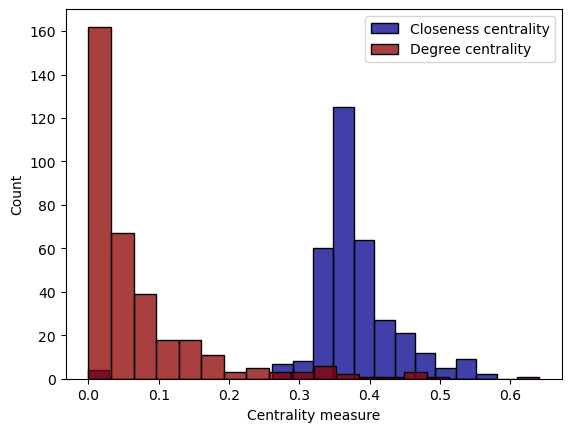

In [17]:
plt.figure()
sns.histplot(x = [float(closenesscentrality[k]) for k in closenesscentrality.keys()], bins = 20, color="darkblue")
sns.histplot(x = [float(degreecentrality[k]) for k in degreecentrality.keys()], bins = 20, color = "darkred")
plt.xlabel("Centrality measure")
plt.legend(["Closeness centrality","Degree centrality"])

## Making the location data
At the momement we have information about what each location of each scene is, but it includes other information such that they cannot be matched. The goal here is to match them with locations only contain the names of the locations in the show

In [19]:
import polars as pl
# Read in the scene_data
D = pd.read_csv('../data/scene_data')
D = pl.from_pandas(D)
# Read in the character metadata and use it to 
# make a list of all characters
metadata = pd.read_csv('../data/characher_metadata2.csv')
metadata_name = list(metadata.iloc[:,0])
metadata_name = set([name.lower() for name in metadata_name])

# Remove a few wierd additions which should not be in the metadata
metadata_name.remove('horse')
metadata_name.remove('file:the riverlands.png')
metadata_name.remove('de:winterfell')
metadata_name.remove('pt-br:winterfell')
metadata_name.remove('the prince of winterfell')
metadata_name.remove("king's landing baker") # Not a location
metadata_name.remove("king's landing rioter") # Not a location
metadata_name.remove("riverlands") # "the riverlands" is allready in the data
# Add list of costum locations which should be compared against. 
locations = []
with open('../data/manual_annotated_locations.csv', "r") as f:
    for line in f:
        locations.append(line.strip())
#Set locations to lower-case
locationsset = set([x.lower() for x in locations])

The goal of the next part is to 1) fuzzy match the scenelocations mentioned for each location with names from an annotated list and with location names from the GoT fandom wiki, which is avalible along with the information about all characters from parsing the GoT fandom wiki. If none match the method also checks if the exact location is in the scene costum location list.

In [20]:
# Make empty column
D=D.with_columns(pl.lit(None).alias('scene_locations'))
# Make list of unique scenes
unique_scenes = D['Scene'].unique()
# Go through each scene
for scene in tqdm(unique_scenes):
    final_rename = None
    og_scene = scene
    scene = scene.lower()
    # Remove unique identifier
    scene = scene.split('_')[0:-1]
    scene =''.join(scene)
    # Remove specific location ie. winterfell – courtyard  or essos, outside yunkai
    if '–' in scene:
        scene = scene.split('–')[0]
        scene =''.join(scene)
    if '-' in scene:
        scene = scene.split('-')[0]
        scene =''.join(scene)
    if ',' in scene:
        scene = scene.split(',')[0]
        scene =''.join(scene)

    # calculate fuz ratio for each location - scene pair. 
    # pick the highest ratio if above threshold
    max_fuzzy_ratio = [0, None, None]
    for name in metadata_name:
        fuzzy_ratio = fuzz.token_sort_ratio(scene, name)
        if fuzzy_ratio > max_fuzzy_ratio[0]:
            max_fuzzy_ratio[0] = fuzzy_ratio
            max_fuzzy_ratio[1] = og_scene
            max_fuzzy_ratio[2] = name
    threshold = 80
    if max_fuzzy_ratio[0] > threshold:
        final_rename = max_fuzzy_ratio
        
    # Now also check pure locations as seen in location vector and take the best of them if they have a good match
    max_fuzzy_ratio = [0, None, None]
    for name in locations:
        fuzzy_ratio = fuzz.token_sort_ratio(scene, name)
        if fuzzy_ratio > max_fuzzy_ratio[0]:
            max_fuzzy_ratio[0] = fuzzy_ratio
            max_fuzzy_ratio[1] = og_scene
            max_fuzzy_ratio[2] = name
    threshold = 80
    if max_fuzzy_ratio[0] > threshold:
        final_rename = max_fuzzy_ratio
        
    # Lastly check if any has the eact location in if none found yet
    if final_rename is None:
        add = False
        to_add = None
        for location in locationsset:
            found = scene.find(location)
            if found != -1:
                add = True
                to_add = location
        if add:
            max_fuzzy_ratio[0] = fuzzy_ratio
            max_fuzzy_ratio[1] = og_scene
            max_fuzzy_ratio[2] = to_add   
            final_rename = max_fuzzy_ratio

    # If found a clear location name, then add it to the dataframe.
    if final_rename is not None:
        D = D.with_columns(pl.when(pl.col('Scene') == final_rename[1])
                        .then(pl.lit(final_rename[2].lower()))
                        .otherwise(pl.col('scene_locations'))
                        .alias('scene_locations')
                          )
D=D.to_pandas()  
# Rename a few locations
D['scene_locations'] = D['scene_locations'].apply(lambda x: 'the iron throne' if x=='iron throne' else x) 
D['scene_locations'] = D['scene_locations'].apply(lambda x: 'The riverlands' if x=='Riverlands' else x) 
D['scene_locations'] = D['scene_locations'].apply(lambda x: 'winterfell' if x=='pl:winterfell' else x) 
# Read to csv
D.to_csv('../data/scene_data_with_location.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 1561/1561 [00:44<00:00, 35.42it/s]


In [21]:
# Create only one Baratheon House
for node, attribute in G.nodes(data=True):
    if "house" in attribute.keys() and attribute["house"][0] in ["House Baratheon of Dragonstone","House Baratheon of King's Landing"]:
        G.nodes(data=True)[node]["house"][0] = "House Baratheon"

In [20]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.02,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=False,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=0.1,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=20)


100%|██████████| 20/20 [00:00<00:00, 523.07it/s]

Repulsion forces  took  0.02  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


<h1> Defining the functions used for plotting the entire network</h1>
One plot function colours the nodes after which house the character belongs to, while the other colours according to which communities the Louvain algorithm calculates

In [21]:
#Helper function, finds the house and degree of each node and adds them to separate lists
def prePlot(Graph,charDegree):
    DegreeList = []
    labels = {}
    HOUSELIST = list()

    for (Character, attributes) in Graph.nodes(data=True):
        if "house" in attributes.keys():
            if attributes["house"] not in HOUSELIST:
                HOUSELIST.append(attributes["house"][0])
        else:
            HOUSELIST.append("No House")
        if Graph.degree()[Character] > charDegree:
            labels[Character] = Character
        DegreeList.append(Graph.degree()[Character])

    return DegreeList, labels, HOUSELIST

# Function to add weights to graph
def edgeWeights(Graph):
    tmpEdgeweights = list()
    colourList = list()
    for (FROM, TO, attributes) in Graph.edges(data=True):
        lineSum = 0
        for season,value in attributes["lines"].items():
            for episode, value2 in value.items():
                for episodename,value3 in value2.items():
                    for key, value4 in value3.items():
                        lineSum += len(value4)
        Graph[FROM][TO]["weight"] = lineSum
        tmpEdgeweights.append(lineSum)
    edgeweights = [x/max(tmpEdgeweights) for x in tmpEdgeweights]
    return edgeweights

# Plotting function
def PlotGraph(Graph, Edges, charDegree = 50):
    DegreeList, labels, HOUSELIST = prePlot(Graph, charDegree)
    edgeweights = edgeWeights(Graph)


    import colorsys

# List of houses
    houses = [
        'House Mallister', 'No House', 'House Egen', 'House Stokeworth', 'House Arryn', 'House Lefford', 'House Corbray', 'Maegyr family',
        'House Mormont', 'House Florent', 'House Stark', 'House Tyrell', 'House Marsh', 'House Thorne', 'House Karstark', 'House Bolton',
        'House Lannister', 'House Dondarrion', 'House Kenning', 'House Royce', 'House Cassel', 'House Tully', 'House Umber', 'House Slynt',
        'House Tollett', 'House Hollard', 'House Rykker', 'House Lannister of Lannisport', 'House Strickland', 'House Reed', 'House of Ullhor',
        'House Seaworth', 'House Selmy', 'House of Loraq', 'House Baratheon', 'House of Nakloz', 'House Baelish', 'House Glover', 'House Tarth',
        'House of Eraz', 'House Redwyne', 'House Bracken', 'House of Qaggaz', 'House Yarwyck', 'House Frey', 'House Clegane', 'House Marbrand',
        'House Martell', 'House Tarly', 'House Payne', 'House Moore', 'House Targaryen', 'House Lorch', "Bronn's house", 'House Greyjoy',
        'House Trant'
    ]

    # Create a dictionary to store the hue value for each house
    hue_mapping = {}

    # Assign hue values to each house
    for i, house in enumerate(houses):
        if house not in hue_mapping:
            hue_mapping[house] = i / len(houses)

    # Convert hue values to RGB colors
    color_mapping = {}
    for house, hue in hue_mapping.items():
        rgb_color = colorsys.hsv_to_rgb(hue, 0.8, 0.8)  # Adjust saturation and value as needed
        color_mapping[house] = rgb_color

    # Convert RGB values to matplotlib-compatible format
    color_mapping = {house: "#{:02x}{:02x}{:02x}".format(int(r * 255), int(g * 255), int(b * 255)) for house, (r, g, b) in color_mapping.items()}

    # Display the color mapping
    node_colors = [color_mapping[color] for color in HOUSELIST]

    # Create a legend with the house names and colors
    legend_labels = [(house, color_mapping[house]) for house in set(HOUSELIST)]
    legend_labels.sort(key=lambda x: x[0])  # Sort legend labels alphabetically

    # Create a custom legend with colored patches
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                                markerfacecolor=color, markersize=10) for label, color in legend_labels]

    nx.draw_networkx_nodes(Graph, positions, node_size=DegreeList, node_color=node_colors, alpha=0.4)

    nx.draw_networkx_edges(Edges, positions, edge_color="green", alpha=edgeweights)
    nx.draw_networkx_labels(Graph, positions, labels=labels, font_size=9)

    plt.legend(handles=legend_patches, title='Houses', loc='upper right', ncol = 4)

    plt.axis('off')
    return

In [24]:
# The graph can also be plotted with the communities calculated by the Louvain algorithm with this function
def PlotGrapWithComm(Graph, Edges, charDegree = 50):
    DegreeList, labels, HOUSELIST = prePlot(Graph, charDegree)
    edgeweights = edgeWeights(Graph)
    
    Graph = Graph.to_undirected()
    import community

    #Creating the best partition
    communities = community.best_partition(Graph)

    # A list of colours to colour the communities
    colourList = ["green","orange","blue","yellow", "purple", "grey", "brown","pink","olive", "tan", "aqua", "navy", "cyan","tomato", "lime", "dimgrey", "teal"]
    count = 0
    for com in set(communities.values()):
        list_nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
        DegreeList = []
        for nodes in list_nodes:
            DegreeList.append(G.out_degree[nodes]*2)
        nx.draw_networkx_nodes(Graph, positions, list_nodes, node_size = DegreeList, node_color = colourList[count], alpha = 0.5)
        count += 1 

    nx.draw_networkx_edges(Edges, positions, edge_color="dimgrey", alpha=edgeweights)
    nx.draw_networkx_labels(Graph, positions, labels=labels, font_size=9)
    plt.axis('off')
    return

<h1>Calling plotting functions</h1>

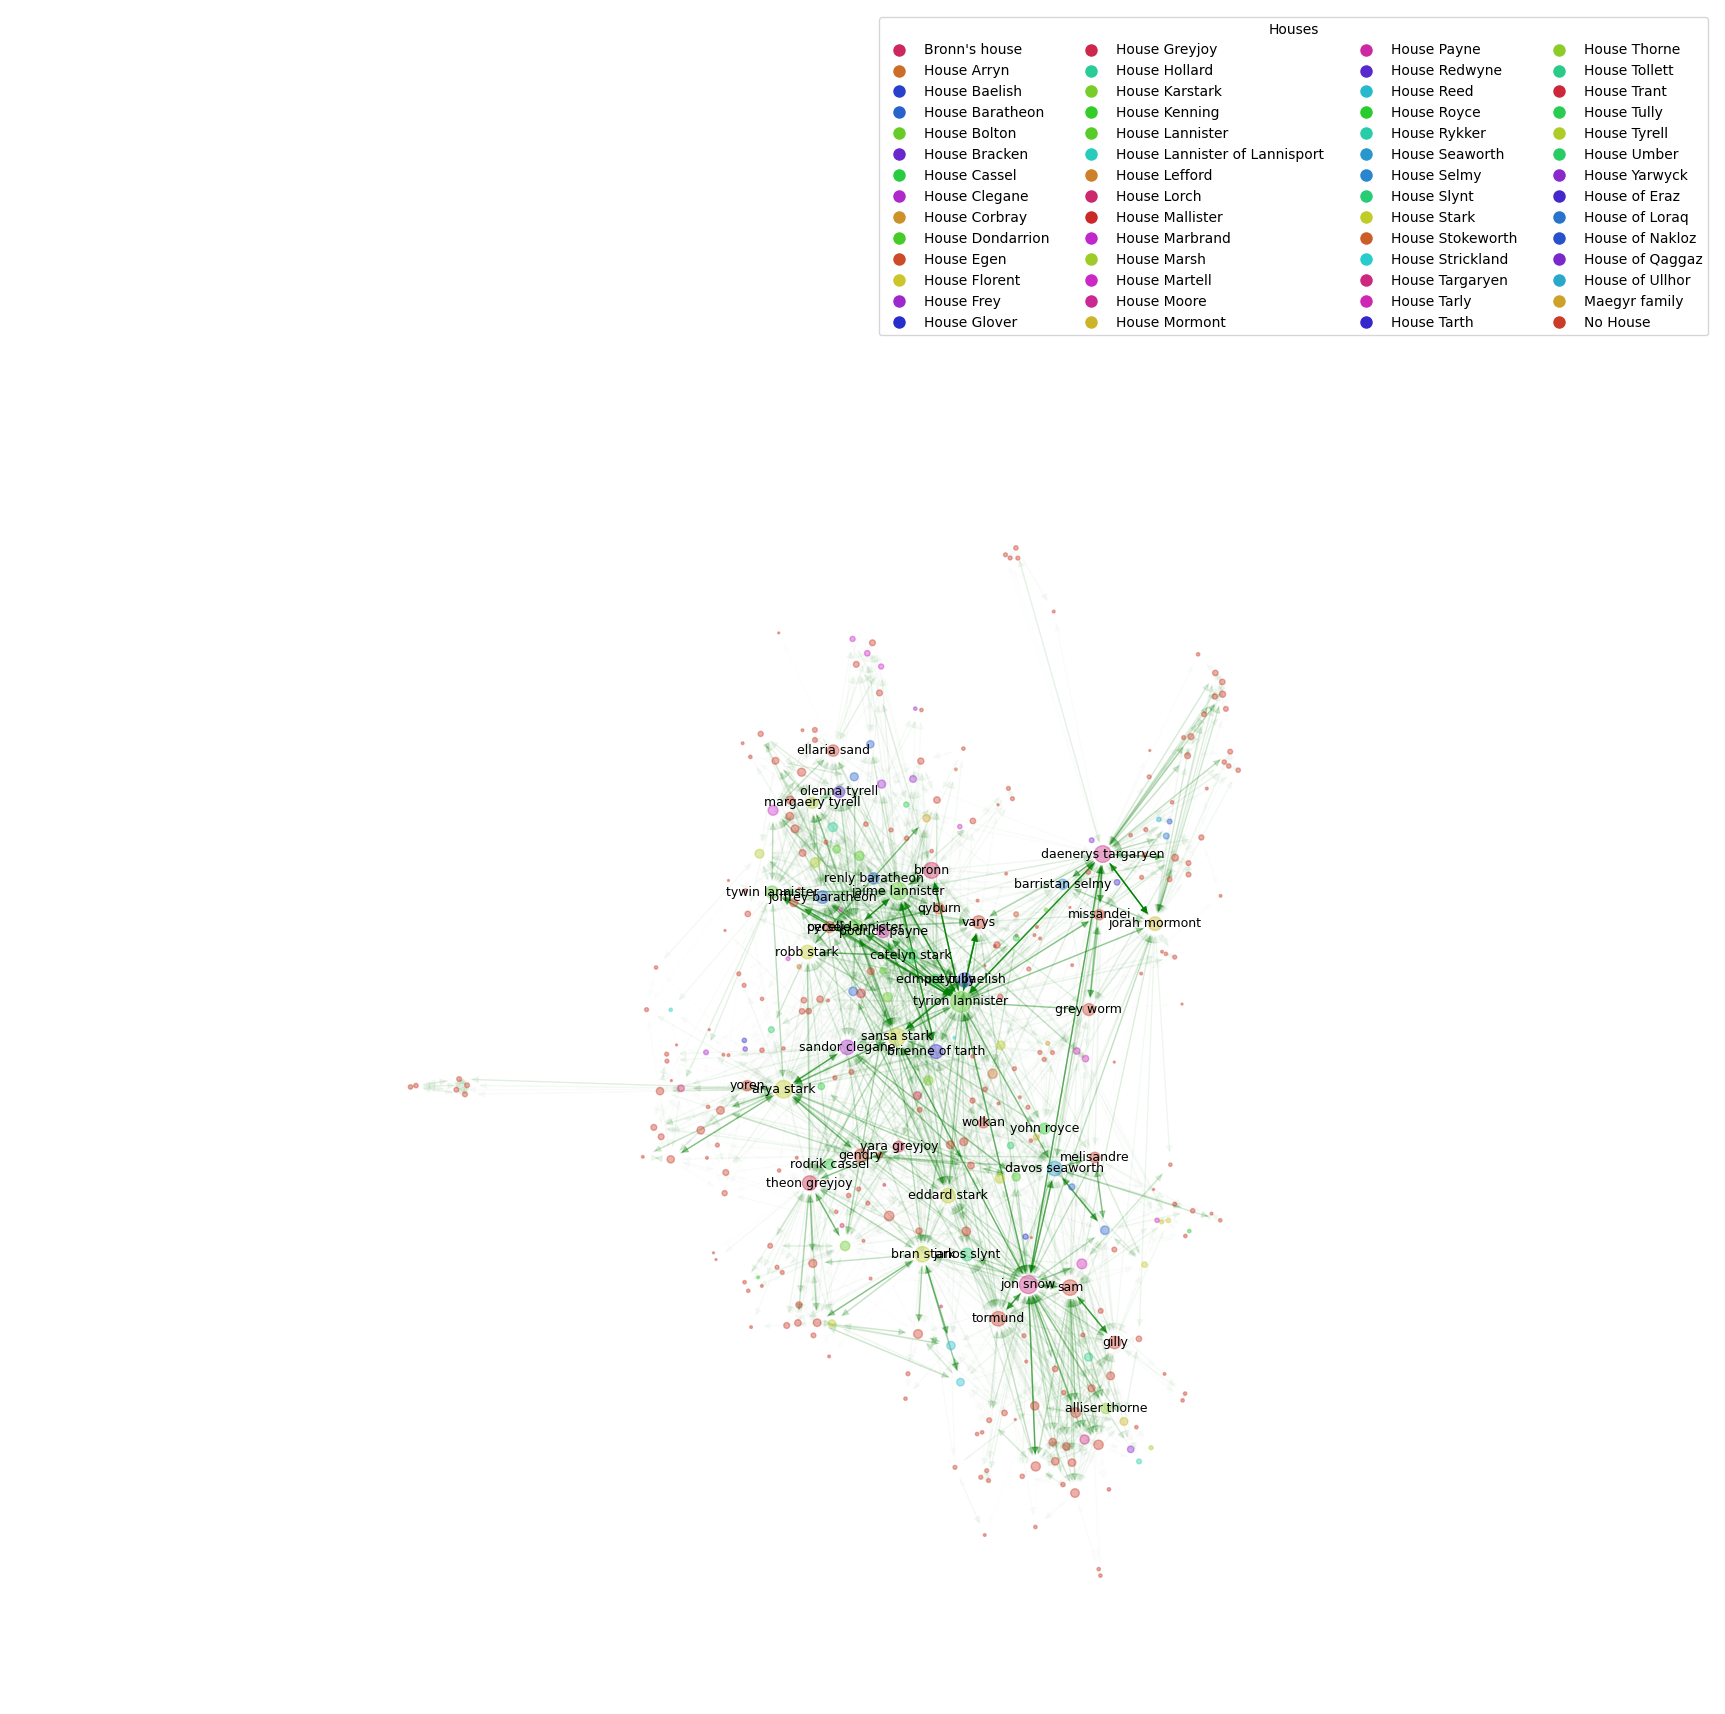

In [22]:
# Calling plot funciton 
plt.figure(figsize= (22,22))
PlotGraph(G,G)
plt.savefig("NetworkWithHouseandlegend.pdf")
plt.show()

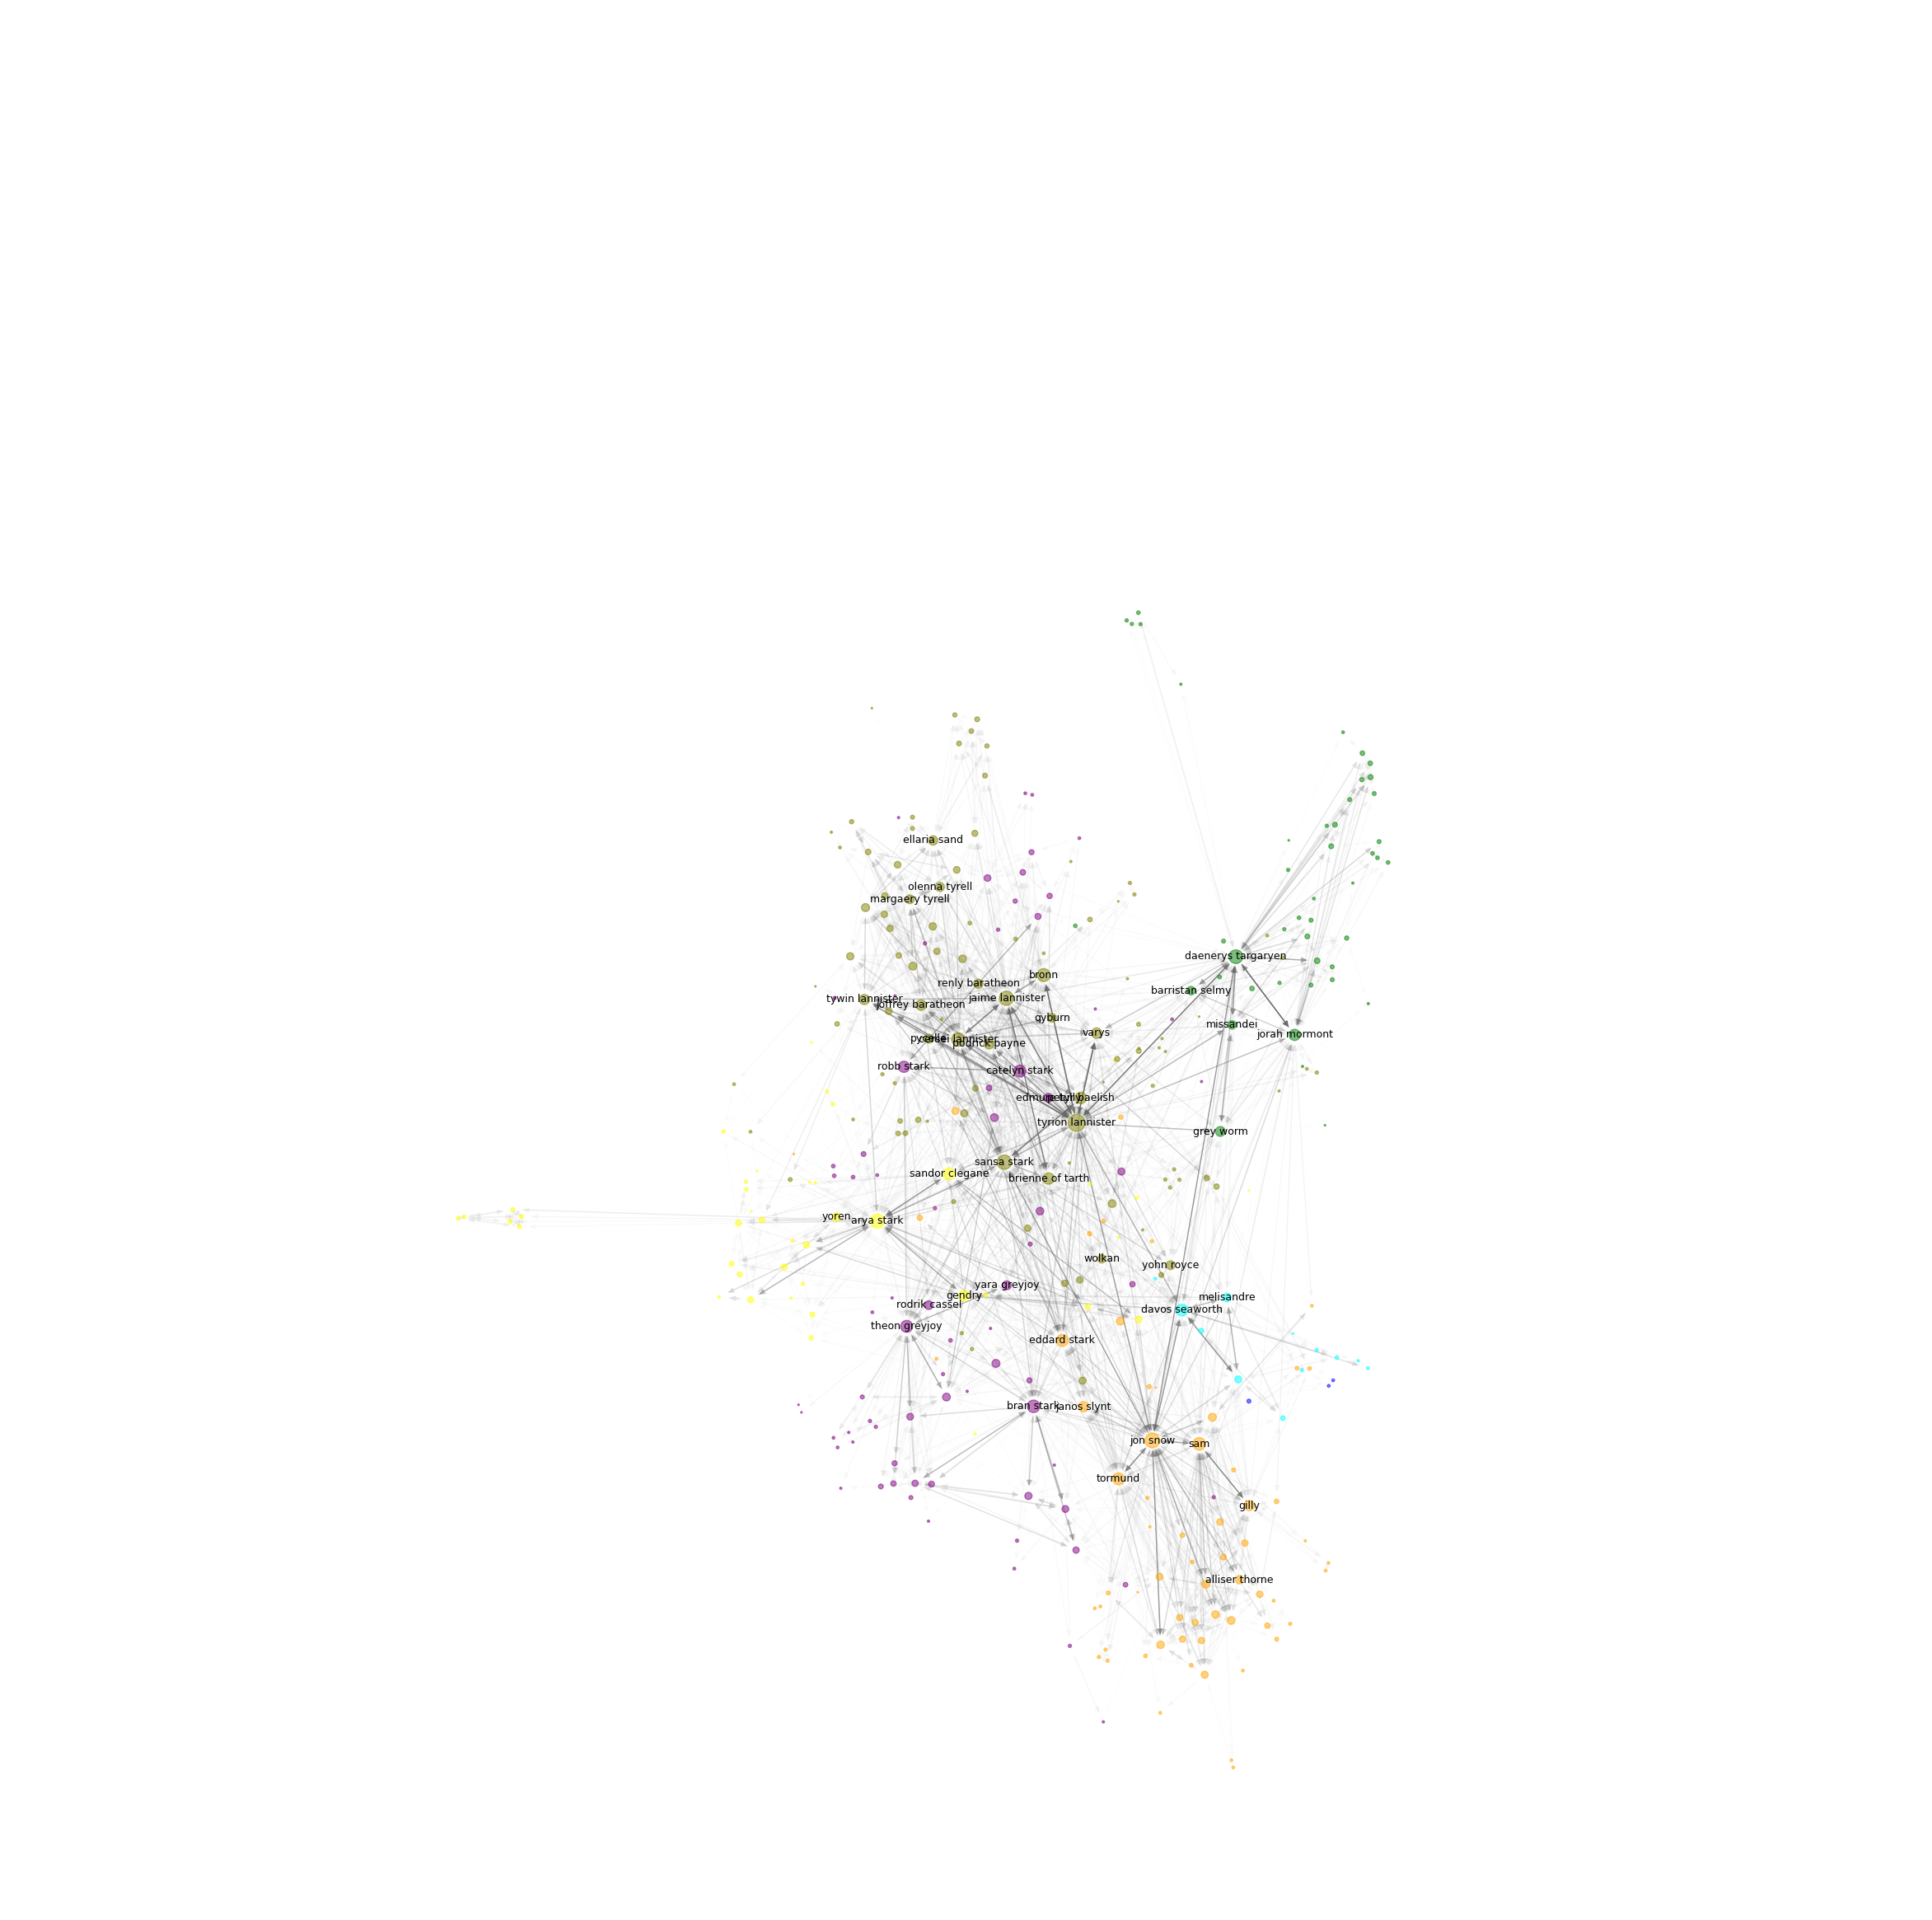

In [25]:
# This graph was not used in the report it uses the Louvain communities
plt.figure(figsize= (30,30))
PlotGrapWithComm(G, G)
plt.savefig("Network2.pdf")


## Plotting the number of lines spoken by each character
#### (did not make it, to the report)

In [36]:
import polars as pl
# Read data from csv
D = pd.read_csv('../data/scene_data_with_location.csv')
D = pl.from_pandas(D)

In [37]:
## Define plot 
def plot_scene_lines(D_not_null, to_plot, to_compare, threshold, ylab):
    from plotnine import ggplot, geom_density, aes, facet_wrap, labs, theme, geom_histogram
    from plotnine.coords import coord_flip
    from plotnine.mapping import after_stat
    from plotnine.themes import theme_minimal
    import numpy as np

    # calculate the number of lines/scenes for each locations
    Dpd = (D_not_null
         .group_by(pl.col(to_compare))
         .agg(pl.col(to_plot).count().alias('number_lines_locations'),  
              pl.col(to_plot).first(), 
              pl.col('SeasonNr').first())
         .to_pandas()
     )
    Dpd['rowcount'] = Dpd.groupby(by=[to_plot])['number_lines_locations'].transform('count')
    
    # apply cutoff depending on threshold
    Dpd = Dpd[Dpd.rowcount > threshold]

    # Make the plot
    plot_final=(ggplot(Dpd, aes(x='SeasonNr',color=to_plot, fill=to_plot))
        + geom_density(aes(y=after_stat('count')), alpha=0.5)
        + facet_wrap('~'+to_plot)
        + labs(x='Season Number',color=to_plot, fill=to_plot, y=ylab)
        + theme_minimal()
        + theme(legend_position='none',)
    )
    return plot_final

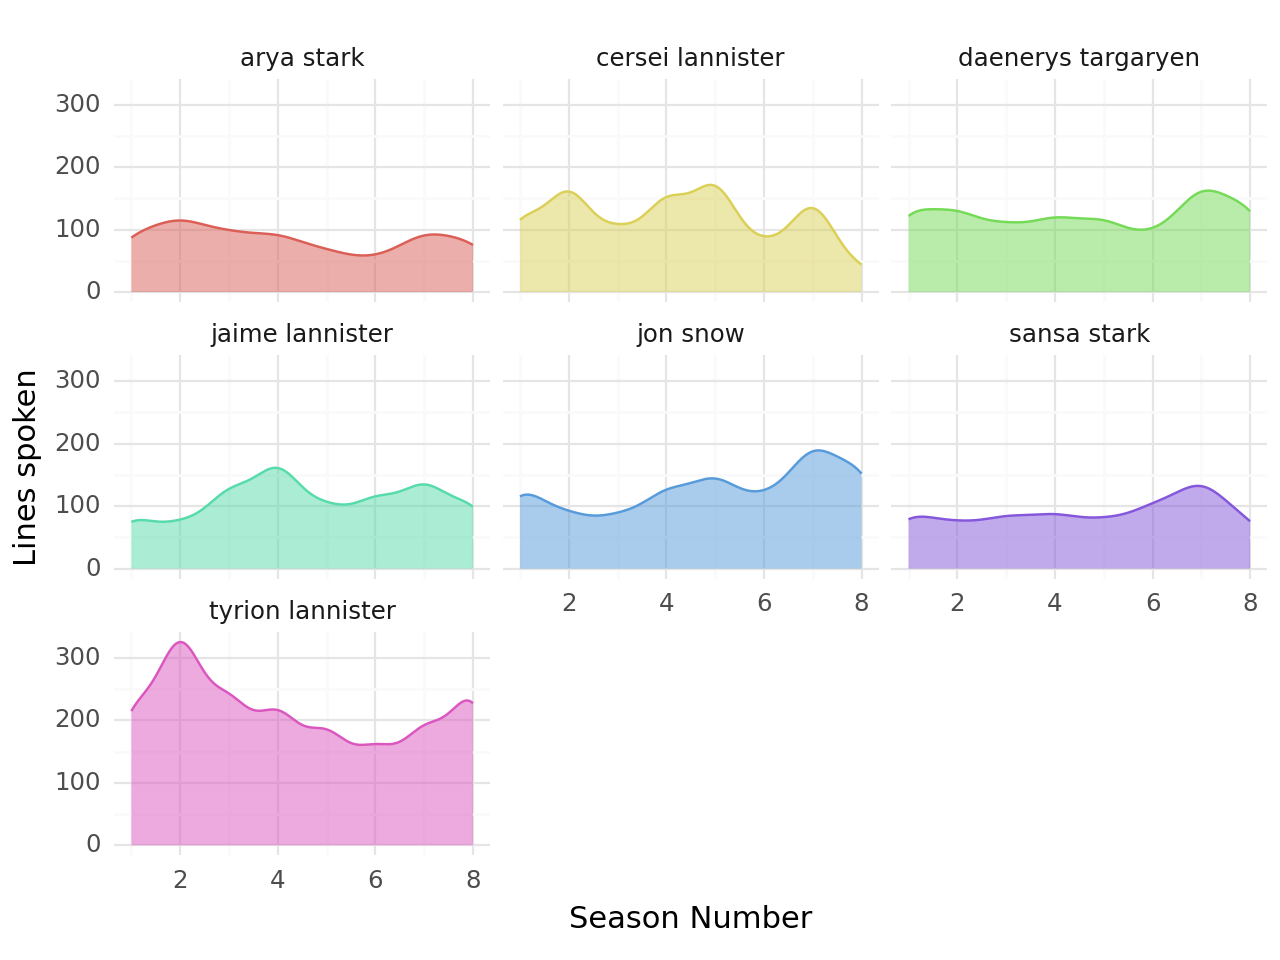

<Figure Size: (640 x 480)>

In [40]:
# Plot the number of lines spoken for each character with over 150 lines spoken
to_plot = 'Person'
to_compare = 'ScreenLine'
# Entries with above threshold to show
threshold = 500
plot_scene_lines(D, to_plot, to_compare, threshold, 'Lines spoken')

## Calculate the degree distribution for the in- and out- degrees combined 

In [31]:
# Read in the network
file = open('GOTNetwork.pkl', "rb")
G = pickle.load(file)
# Extract the degree distribution
degree_sequence = [d for n, d in G.degree()]
# Fit a power law to the network
powerlaw.Fit(degree_sequence).alpha

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


2.6120461668304276

<h1>Finding the nodes with the highest and the lowest degrees.
</h1>
<h4> The lowest is not very informative as it is of course very minor characters so it did not make into the report</h4>

In [32]:

TotalSorted = max(dict(G.degree()).items(), key = lambda x : x[1])
print("Most connected character is", TotalSorted[0].title(),"with a degree of", TotalSorted[1], "" )
MostConnected = sorted(dict(G.degree).items(), key = lambda x : x[1], reverse= True)
LeastConnected = sorted(dict(G.degree).items(), key = lambda x : x[1])
print("The 10 most connected characters:")
x = [print(str(i+1)+".",w[0],"with", w[1], "edges" ) for w,i in zip(MostConnected, range(0,10))]

Most connected character is Tyrion Lannister with a degree of 220 
The 10 most connected characters:
1. tyrion lannister with 220 edges
2. jon snow with 168 edges
3. sansa stark with 158 edges
4. arya stark with 158 edges
5. jaime lannister with 156 edges
6. daenerys targaryen with 144 edges
7. cersei lannister with 138 edges
8. bronn with 130 edges
9. sam with 124 edges
10. bran stark with 120 edges


<h1>Degree distribution plots </h1> <h4> Did not make it into report</h4>

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


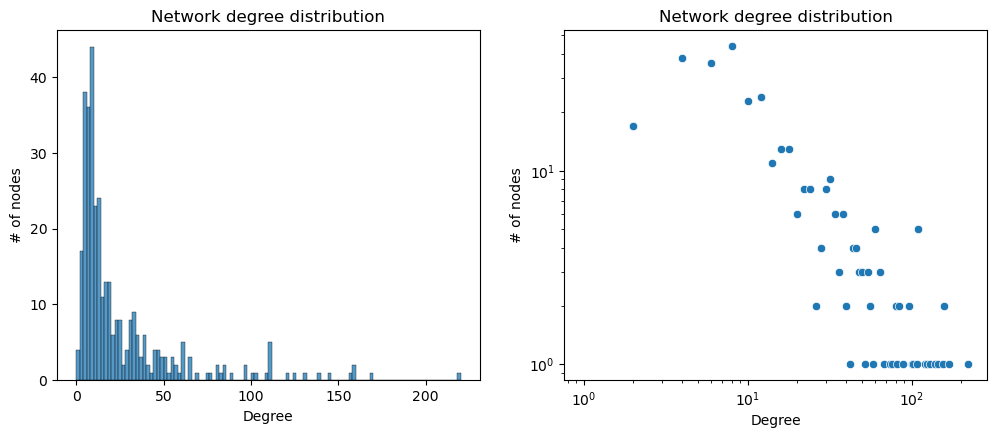

In [33]:
# Degree distribution plots 
degree_sequence = sorted((d for n, d in G.degree()), reverse =True)

INbins = np.arange(min(degree_sequence), max(degree_sequence)+1)

pmf = [(degree_sequence == bin).sum() for bin in INbins]
pmf = np.array(pmf)

plt.figure(figsize=(12,10))
plt.subplot(221)
sns.histplot(degree_sequence,binwidth = 2)
plt.title("Network degree distribution")
plt.ylabel("# of nodes")
plt.xlabel("Degree")

plt.subplot(222)
sns.scatterplot(y = pmf, x = INbins)
plt.title("Network degree distribution")
plt.ylabel("# of nodes")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Degree")
plt.show()

## Degree distribution for the weighted in- and out-degrees

In [34]:
# Define a function to get all the lines from the network metadata
def get_lines(node):
    out = []
    for x in node[2]['lines'].values():
        for x in x.values():
            for x in x.values():
                for x in x.values():
                    out += x
    return out

# Create a list in which to add all the metadata w.r.t. lines spoken from the network
edges = list()
x=0
# Go thorugh each edge and add the metadata
for edge in list(G.edges(data=True)):
    to_add = dict()
    from_node = edge[0]
    to_node = edge[1]
    lines = get_lines(edge)
    
    to_add['from_node'] = from_node
    to_add['to_node'] = to_node

    # Make sure not to count the number of chars if lines is not a list
    if isinstance(lines, list):
        to_add['n_lines'] = len(lines)
    else:
        to_add['n_lines'] = 1
    edges += [to_add]
# Read the data into a dataframe
df = pd.DataFrame.from_dict(edges)

<h1>Finding the longest shortest path of the network</h1>

In [35]:
# Finding the longest shortest path in the network
ppp=nx.all_pairs_dijkstra_path_length(G)
longestShortest = 0
for i in ppp:
  node=max(i[1], key=i[1].get)
  if len(nx.shortest_path(G,i[0],node)) > longestShortest:
    longestShortest = len(nx.shortest_path(G,i[0],node))

print(longestShortest)

6


In [36]:
# Extract the in-and out degree's from the above defined dataframe
indegrees = df.groupby('to_node').agg(indegree = ('n_lines','sum'))['indegree'].to_numpy()
outdegrees = df.groupby('from_node').agg(outdegree = ('n_lines','sum'))['outdegree'].to_numpy()
# Fit a powerlaw to the weighted indegrees
powerlaw.Fit(indegrees).alpha
# Fit a powerlaw to the weighted outdegrees
powerlaw.Fit(outdegrees).alpha

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


2.824122678347856

#### Making table 1, weighted in and out degrees

In [37]:
# Print a list of the nodes with the highest weighted out- and in- degrees
indegrees = df.groupby('to_node').agg(indegree = ('n_lines','sum'))['indegree']
outdegrees = df.groupby('from_node').agg(outdegree = ('n_lines','sum'))['outdegree']
print('##### weighted out degree #####')
print(outdegrees.sort_values(ascending=False).iloc[0:6])
print('##### weighted in degree #####')
print(indegrees.sort_values(ascending=False).iloc[0:6])

##### weighted out degree #####
from_node
tyrion lannister      4739
jon snow              3432
daenerys targaryen    2811
cersei lannister      2367
jaime lannister       2015
sansa stark           1925
Name: outdegree, dtype: int64
##### weighted in degree #####
to_node
tyrion lannister      2917
jon snow              2356
sansa stark           1904
jaime lannister       1824
cersei lannister      1708
daenerys targaryen    1674
Name: indegree, dtype: int64


<h1>Lix score analysis</h1>

In [38]:

# Lix Score function
def Lix(listoftext):
    senctenceList = listoftext
    P = len(senctenceList)
    L = 0
    O = 0
    for sentence in senctenceList:
        O += len(sentence.split(" "))
        for word in sentence.split(" "):
            if len(word) > 6:
                L += 1            
    lixNumber = O/P + L*100/O


    return lixNumber

In [42]:
# Extracts the text that each character speaks and adds it to a dictionary
textDict = dict()
textSet = set()
for FROM, TO in G.out_edges():
    for season, val in G.out_edges[(FROM,TO)].items():
        if season != "weight":
            for episode, val2 in val.items():
                for epiname,val3 in val2.items():
                    for location, val4 in val3.items():
                        for dialogue in val4.values():
                            for text in dialogue:
                                if text not in textSet:
                                    textSet.add(text)
                                    if FROM not in textDict.keys():
                                        textDict[FROM] = list()
                                    textDict[FROM].append(text)


In [40]:

#Calculate the lix score of the characters
lixDict = dict()
for key in textDict.keys():
    lixDict[key] = Lix(textDict[key])

# create a list of the houses the characters belong to
HouseList = []
for name in lixDict.keys():
    if "house" in G.nodes[name].keys():
        HouseList.append(G.nodes[name]["house"][0])
    elif "affiliation" in G.nodes[name].keys():
        HouseList.append(G.nodes[name]["affiliation"][0])
    else:
        HouseList.append("No House")
df = pd.DataFrame()

df["Houses"] = HouseList
df["Names"] = lixDict.keys()
df["Values"] = lixDict.values()
df =df.sort_values(by="Houses")

In [58]:
#Calculating the total lines spoken by each character
edgeWeights(G)
TyrionLines = 0
weightDict = dict()

for FROM, TO in G.edges():
    if "weight" in G.edges[FROM,TO]:
        if FROM not in weightDict.keys():
            weightDict[FROM] = G.edges[FROM,TO]["weight"]
        else:
            weightDict[FROM] += G.edges[FROM,TO]["weight"]

In [59]:
#Create two node lists. One where characters have over 50 degrees and one where they have over 15
# To be used to limit data amount and to not include characters that have very few lines of dialogue
Over50DegreeList = [x for x in G.nodes() if G.degree(x) > 50]
Over15DegreeList = [x for x in G.nodes() if x in weightDict.keys() and weightDict[x] > 50]
print(Over15DegreeList)
df2 = df.loc[df["Names"].isin(Over50DegreeList)]
df3 = df.loc[df["Names"].isin(Over15DegreeList)]

['yoren', 'olyvar', "night's watch", 'tormund', 'pypar', 'ros', 'mero', 'melessa tarly', 'brynden tully (blackfish)', 'lancel lannister', 'craster', 'dontos hollard', 'cersei lannister', 'sparrow', 'tommen baratheon', 'mace tyrell', 'balon greyjoy', 'catelyn stark', 'xaro xhoan daxos', 'alton lannister', 'eddard stark', 'rakharo', 'euron greyjoy', 'matthos', 'daario naharis', 'greatjon umber', 'thoros', 'robert baratheon', 'camello', 'bran stark', 'grey worm', 'sansa stark', 'bronn', 'loras tyrell', 'roose bolton', 'locke', 'three-eyed raven', 'jojen reed', 'varys', 'dolorous edd', 'sandor clegane', 'viys targaryen', 'lyanna stark', 'jon snow', 'podrick payne', 'kevan lannister', 'grenn', 'khal drogo', 'tanner', 'melisandre', 'brienne of tarth', 'eddison tollett', 'ramsay bolton', 'styr', 'meera reed', 'dickon tarly', 'jory cassel', 'randyll tarly', 'orell', 'rast', 'daenerys targaryen', 'myrcella baratheon', 'bobono', 'walder frey', 'wolkan', 'robb stark', 'smalljon umber', 'obara san

c:\Users\anton\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


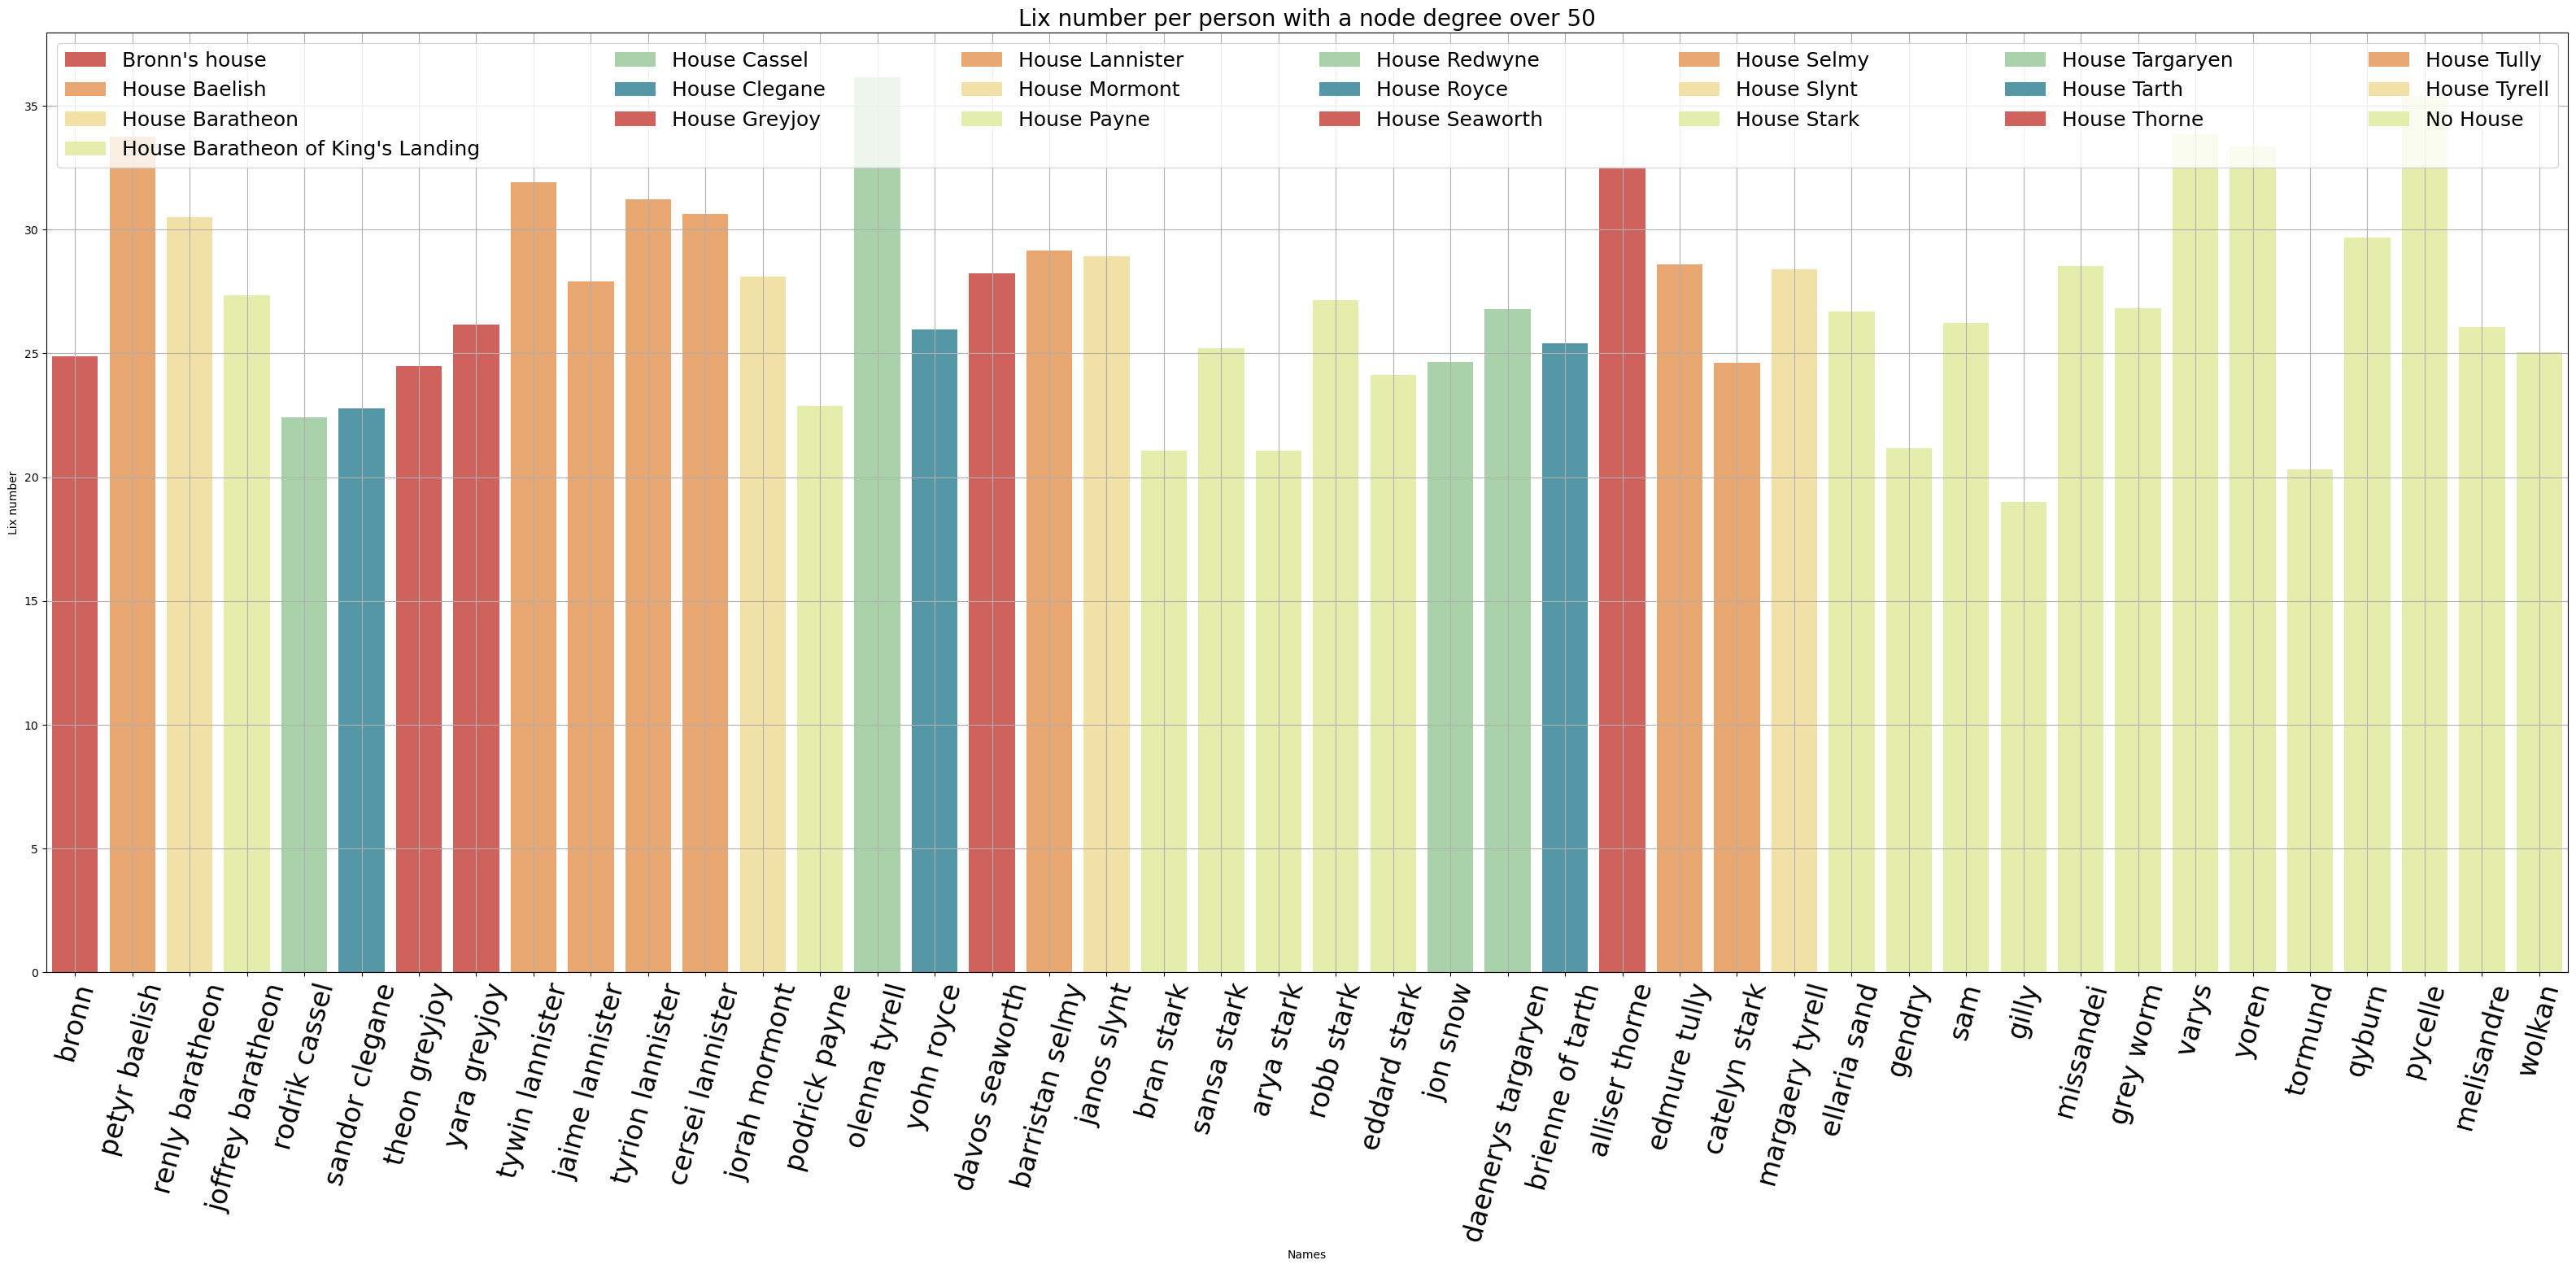

In [45]:
# Plotting the barchart of the lix scores
plt.figure(figsize=(40,15))
ax = sns.barplot(y = "Values", x= "Names", hue = "Houses",data = df2, dodge=False, palette= sns.color_palette("Spectral"))
plt.title("Lix number per person with a node degree over 50", fontsize = 20)
plt.ylabel("Lix number")
plt.grid(True,which="major")
sns.move_legend(ax,loc="upper center")
plt.xticks(rotation = 75, fontsize = 24)
plt.legend(mode = "expand",   ncol = 7, fontsize = 18)
plt.show()

In [60]:
import random
random.seed(100)
# Calculating the mean of the Lannister Lix scores
LannisterMean = (lixDict["jaime lannister"] + lixDict["tywin lannister"]+ lixDict["tyrion lannister"]+ lixDict["cersei lannister"])/4
lixNumbers = list(lixDict.values())

#Creating a list of of means from randomly chosen lix values
meanList = []
N = 10000
for i in range(N):
    unshuffledList = list(df3["Values"])
    random.shuffle(unshuffledList)
    avg = np.mean(unshuffledList[0:4]) #Taking the mean of randomly chosen lix values 
    meanList.append(avg) 
meanList = np.array(meanList)

# Reporting the percentage of means that higher than the Lannister mean
print(len(meanList[meanList>LannisterMean])/N *100,"%")

5.9799999999999995 %


<h1>Sentiment analysis</h1>

Loading the csv file called scene_data which contains the collected data about spoken lines and metadata, created earlier in this document.

In [41]:
df = pd.read_csv("../data/scene_data.csv")
locdf = pd.read_csv("../data/scene_data_with_location.csv")
df["SceneLocations"] = locdf["scene_locations"]
df.drop(columns="Unnamed: 0")


Person  SeasonNr  EpisodeID      EpisodeTitle  \
0          waymar royce         1          1  winter is coming   
1                  will         1          1  winter is coming   
2          waymar royce         1          1  winter is coming   
3                  will         1          1  winter is coming   
4                 gared         1          1  winter is coming   
...                 ...       ...        ...               ...   
23629               sam         8         73   the iron throne   
23630             bronn         8         73   the iron throne   
23631  brienne of tarth         8         73   the iron throne   
23632             bronn         8         73   the iron throne   
23633  tyrion lannister         8         73   the iron throne   

                         Scene  \
0                      Unknown   
1                      Unknown   
2                      Unknown   
3                      Unknown   
4                      Unknown   
...                        ...   
23629  SMALL COUNCIL CHAMBER_4   
23630  SMALL COUNCIL CHAMBER_4   
23631  SMALL COUNCIL CHAMBER_4   
23632  SMALL COUNCIL CHAMBER_4   
23633  SMALL COUNCIL CHAMBER_4   

                                              ScreenLine            House  \
0      What d'you expect? They're savages. One lot st...      House Royce   
1      I've never seen wildlings do a thing like this...              NaN   
2                                 How close did you get?      House Royce   
3                                Close as any man would.              NaN   
4                       We should head back to the wall.              NaN   
...                                                  ...              ...   
23629  Uh... the Archmaester is less than enthusiasti...              NaN   
23630      Well, I imagine he isn't using them properly.    Bronn's house   
23631  I think we can all agree that ships take prece...      House Tarth   
23632      I think that's a very presumptuous statement.    Bronn's house   
23633  I once brought a jackass and a honeycomb into ...  House Lannister   

                                            Affiliations   SceneLocations  
0                                          Night's Watch              NaN  
1                                          Night's Watch              NaN  
2                                          Night's Watch              NaN  
3                                          Night's Watch              NaN  
4                                          Night's Watch              NaN  
...                                                  ...              ...  
23629                                                NaN  council chamber  
23630  Catelyn Stark, House Lannister, City Watch of ...  council chamber  
23631  House Baratheon, Kingsguard, Renly Baratheon, ...  council chamber  
23632  Catelyn Stark, House Lannister, City Watch of ...  council chamber  
23633  House Baratheon of King's Landing, Small Counc...  council chamber  

[23634 rows x 9 columns]

The wordTokenize function is a function that tokenizes and lemmatizes a string, and removes stopwords and other specified words. 

The plotFreqdist is a function that plots frequency distributions given a distribution. 

In [42]:
def wordTokenize(wordString: str):
    wnl = nltk.WordNetLemmatizer()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    other_words = set(["n't"])
    stop_words = stop_words.union(other_words)
    tokens = nltk.tokenize.word_tokenize(wordString)

    filtered_tokens = [i.lower() for i in tokens if i.lower() not in list(string.punctuation) and re.match(f'\w+',i.lower()) and i.lower() not in stop_words]
    lemmatizedTokens = [wnl.lemmatize(t) for t in filtered_tokens]
    lemmatizedTokensUnfiltered = [wnl.lemmatize(t) for t in tokens]
    freqdist = nltk.FreqDist(lemmatizedTokens)
    return tokens, filtered_tokens, lemmatizedTokens, lemmatizedTokensUnfiltered, freqdist
    

def plotFreqdist(freqdist, title, nrofwordstoshow = 75):
    plt.figure(figsize=(15,6))
    freqdist.plot(nrofwordstoshow, title = title)

The function below takes a two columns from a dataframe and concatenates them, forming a dict where the key is eg. a character, and the values are the lines that character says.

In [43]:
def concatLinesby(df1, dflines):
    linesDict = dict()
    for group, lines in zip(df1,dflines):
        if lines != np.nan and group != np.nan and str(group) != "nan" and str(lines) != "nan":         
            if len(group.split(", ")) > 1:
                for d in group.split(", "):
                    #print(d)
                    
                    if d not in linesDict:
                        linesDict[d] = ""
                    try:
                        linesDict[d] += " " + lines
                    except TypeError:
                        print("Error:", d, lines)
            else:
                if group not in linesDict:
                    linesDict[group] = ""
                try:
                    linesDict[group] += " " + lines
                except TypeError:
                    print("Error:", group, lines)
        else:
            pass
    return linesDict



Below the house column of the dataframe is concatenated with the lines and a frequency distribution of the tokens are shown in the plot. 

This plot is not used in the report.

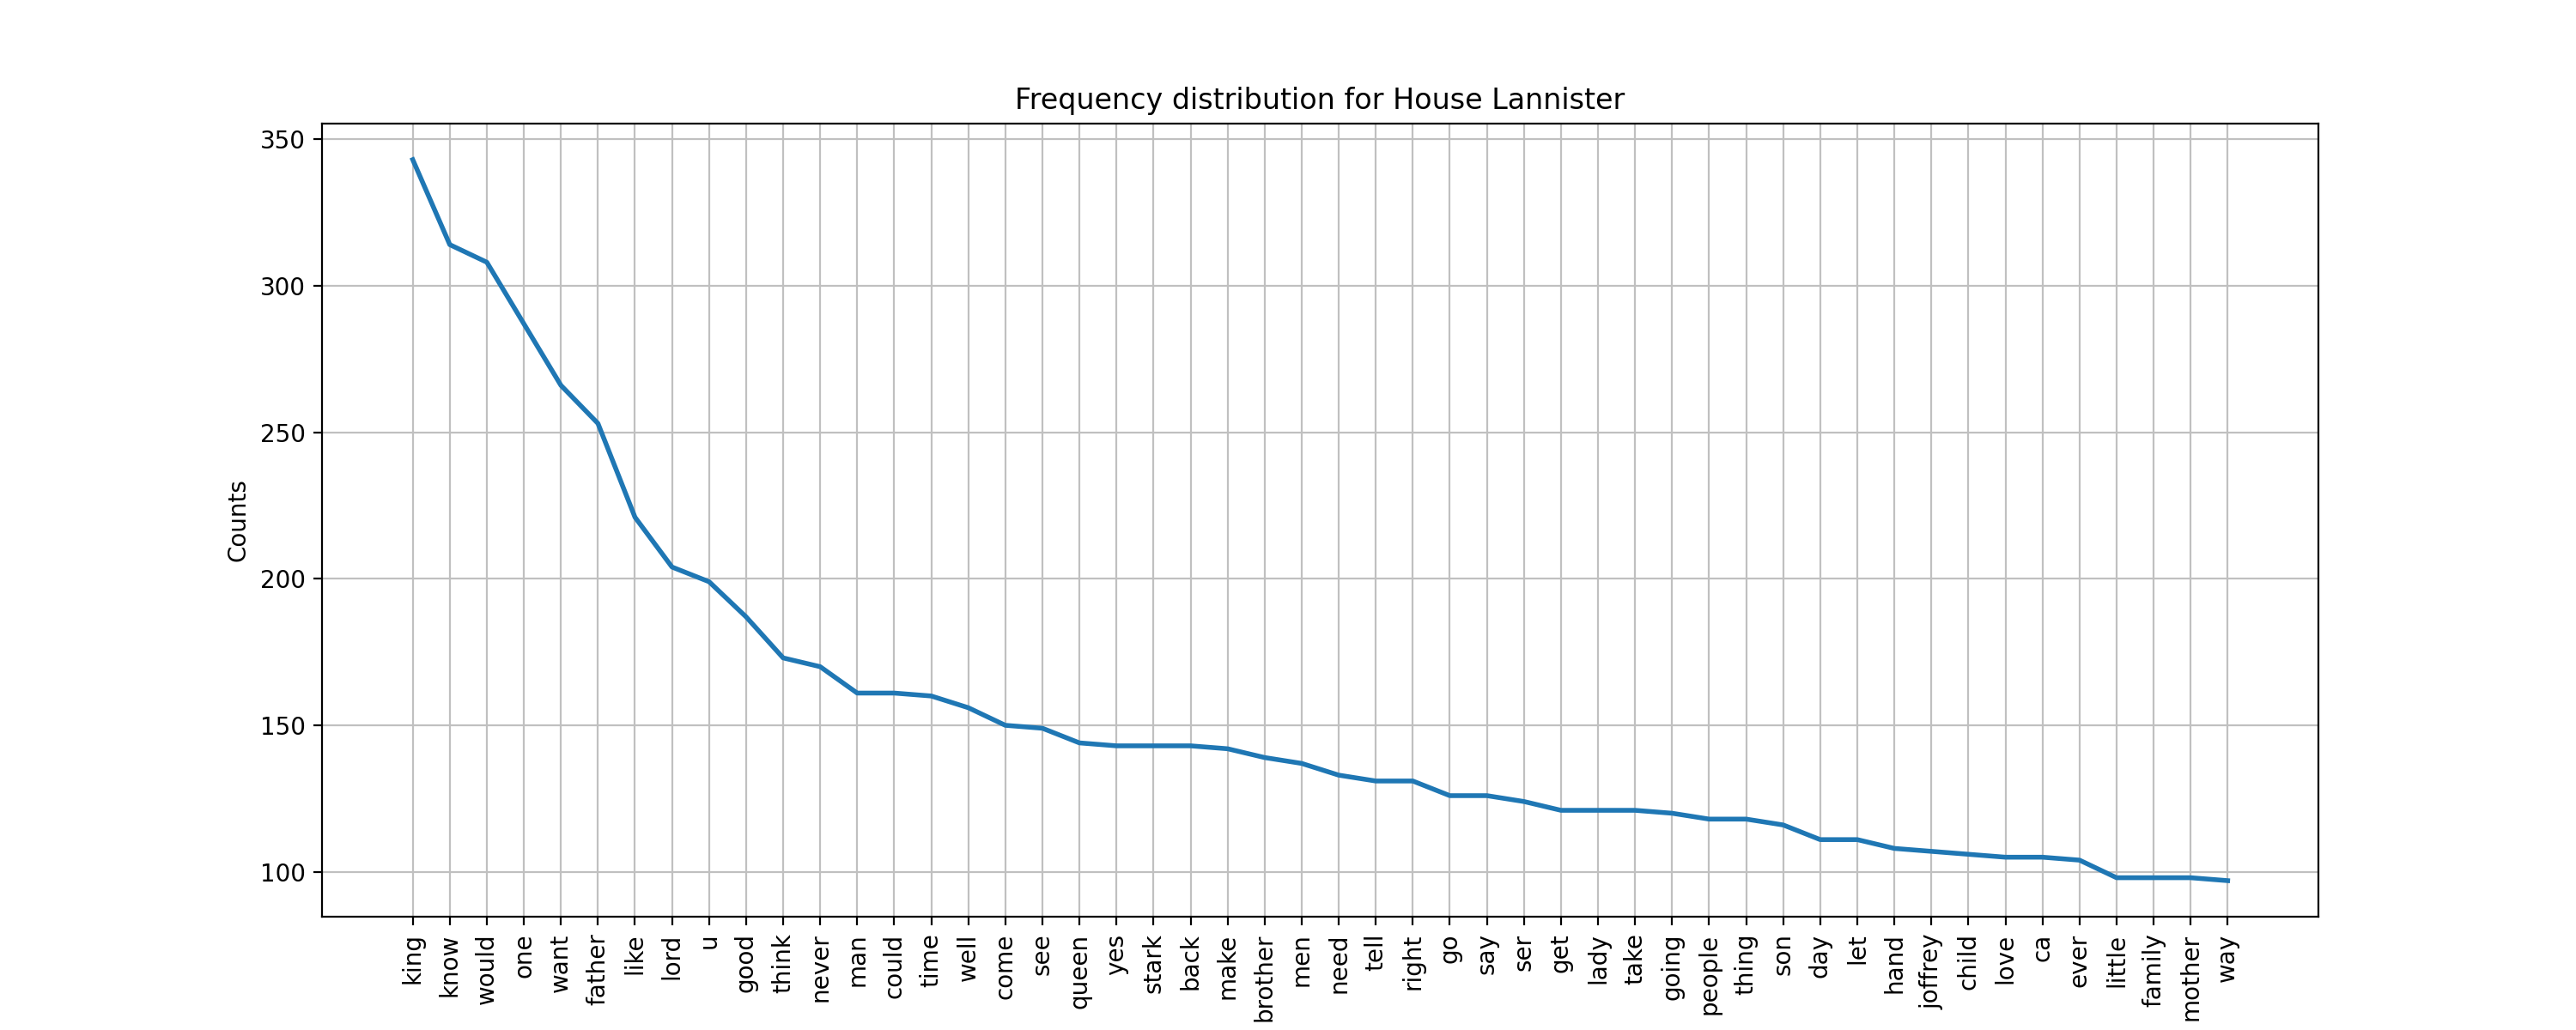

In [47]:
houseLinesDict = concatLinesby(df["House"],df["ScreenLine"])
freqdist = wordTokenize(houseLinesDict["House Lannister"])[4]


plotFreqdist(freqdist, "Frequency distribution for House Lannister", nrofwordstoshow= 50)

Here, the nltk package is used to write some lines that the House Lannister might say. They don't sound particularly realistic. 

This is not used in the report.

In [48]:
txt = nltk.Text(wordTokenize(houseLinesDict["House Lannister"])[1])
txt.generate()

Building ngram index...


placed high value brother life lannister might lowest lannisters one
us every day girl prayed somewhere else back ever stannis baratheon
sacks city takes iron throne confessed crimes gave irrefutable
evidence guilt would matter cersei wo rest head spike offering
knighthood whomever finds sansa stark eldest daughter lord eddard last
spoke offered counsel allow return courtesy bend knee grace nothing
strips bold notions man head like melon high sparrow head every
sparrow head every sparrow head like melon high sparrow looks
surprised faith crown two pillars hold world one collapses must
everything necessary protect one another send raven message
littlefinger


'placed high value brother life lannister might lowest lannisters one\nus every day girl prayed somewhere else back ever stannis baratheon\nsacks city takes iron throne confessed crimes gave irrefutable\nevidence guilt would matter cersei wo rest head spike offering\nknighthood whomever finds sansa stark eldest daughter lord eddard last\nspoke offered counsel allow return courtesy bend knee grace nothing\nstrips bold notions man head like melon high sparrow head every\nsparrow head every sparrow head like melon high sparrow looks\nsurprised faith crown two pillars hold world one collapses must\neverything necessary protect one another send raven message\nlittlefinger'

Below is a function for calculating sentiment using the vader sentiment package. These results were used preliminarily, but the function was later replaced with another function, using the LabMT wordlist for sentiment analysis, shown in the cell two cells below.

In [49]:
def updateDict(dictionaryindexed, sc):
    dictionaryindexed["neg_score"] += sc["neg"]
    dictionaryindexed["pos_score"] += sc["pos"]
    dictionaryindexed["neu_score"] += sc["neu"]
    dictionaryindexed["summed_compound"] += sc["compound"]
    
    dictionaryindexed["sentence_count"] += 1
    dictionaryindexed["neg_count"] += 1
    dictionaryindexed["pos_count"] += 1
    return dictionaryindexed

def sentimentAnalysisbyGroup(df1, dflines):
    sidobj = vs.SentimentIntensityAnalyzer()
    sentScoreDict = dict()
    for group, lines in zip(df1,dflines):
        if lines != np.nan and group != np.nan and str(group) != "nan" and str(lines) != "nan":         
            
            if len(str(group).split(", ")) > 1:
                for d in str(group).split(", "):
                    #print(d)
                    
                    if d not in sentScoreDict:
                        sentScoreDict[d] = {"summed_compound": 0, "neg_score": 0, "pos_score": 0, "neu_score": 0, "sentence_count": 0, "neg_count": 0, "pos_count" : 0}
                    try:
                        sc = sidobj.polarity_scores(lines)
                        sentScoreDict[d] = updateDict(sentScoreDict[d],sc)
                    except TypeError:
                        print("Error:", d, lines)
            else:
                if group not in sentScoreDict:
                    sentScoreDict[group] = {"summed_compound": 0, "neg_score": 0, "pos_score": 0, "neu_score": 0, "sentence_count": 0, "neg_count": 0, "pos_count" : 0}
                try:
                    sc = sidobj.polarity_scores(lines)
                    sentScoreDict[group] = updateDict(sentScoreDict[group],sc)
                except TypeError:
                    print("Error:", group, lines)
    for group in sentScoreDict:
        sentScoreDict[group]["avg_sentiment"] = sentScoreDict[group]["summed_compound"] / sentScoreDict[group]["sentence_count"]
    return sentScoreDict

The sentiment used in the report is calculated using the sentimentFunction defined below, which returns the overall sentiment for a list of tokens. 

In [50]:
# Loading the labmt wordlist and creating a wordlist dictionary
wordlist = pd.read_csv("../data/SentimentML.tsv", sep = "\t")
worddict = {word:float(hapavg) for word, hapavg in zip(wordlist.word, wordlist.happiness_average)}

def sentimentFunction(listoftokens):
    sentiment = 0
    fdist = nltk.FreqDist(tk.lower() for tk in listoftokens)
    freqsum = 0
    for token in sorted(fdist):
        if token in worddict:
            freq = float(fdist[token])
            freqsum += freq
            sentiment += freq * worddict[token]

    if freqsum == 0:
        return 0
    
    return sentiment

The sentimentAnalysis function takes two columns in the dataset along with the column containing the lines spoken, and returns a dictionary containing a sentiment score for all lines spoken. Eg it can be used to see the sentiment score of a characters lines (eg. df1), grouped by the 8 seasons. Or it could show the sentiment of a house through episodes, etc. 
The other function does the same thing, but only for a single column.

In [51]:
def sentimentAnalysisbyGroupMT(df1, df2, dflines):
    
    sentScoreDict = dict()
   
    for group, group2, lines in zip(df1,df2,dflines):
        try: 
            lemmatizedTokens = wordTokenize(lines)[2]
            if group not in sentScoreDict:
                sentScoreDict[group] = {}
            if group2 not in sentScoreDict[group]:
                sentScoreDict[group][group2] = {"summed_compound": 0, "token_count" : 0}
                
            sentScoreDict[group][group2]["summed_compound"] += sentimentFunction(lemmatizedTokens)
            sentScoreDict[group][group2]["token_count"] += len(lemmatizedTokens)
            
        except TypeError as error:
            #print(error)
            pass
        
    
    for group in sentScoreDict:
        for group2 in sentScoreDict[group]:
            try:
                sentScoreDict[group][group2]["avg_sentiment"] = sentScoreDict[group][group2]["summed_compound"] / sentScoreDict[group][group2]["token_count"]
            except ZeroDivisionError as error:
                pass
    

    return sentScoreDict
def sentimentAnalysisbyGroupMT2(df1, dflines):
    
    sentScoreDict = dict()
   
    for group, lines in zip(df1, dflines):
        try: 
            lemmatizedTokens = wordTokenize(lines)[2]
            if group not in sentScoreDict:
                sentScoreDict[group] = {"summed_compound": 0, "token_count" : 0}
            
                
            sentScoreDict[group]["summed_compound"] += sentimentFunction(lemmatizedTokens)
            sentScoreDict[group]["token_count"] += len(lemmatizedTokens)
            
        except TypeError as error:
            #print(error)
            pass
        
    
    for group in sentScoreDict:
        try:
            sentScoreDict[group]["avg_sentiment"] = sentScoreDict[group]["summed_compound"] / sentScoreDict[group]["token_count"]
        except ZeroDivisionError as error:
            pass
    

    return sentScoreDict

The sentiment of each persons lines for each season is calculated here. The three characters, Arya, Ramsay and Theon are selected for plotting, and thus a list containing the sentiment for each timepoint is created. A corresponding list with the names for the labels in the plot are created along with a range, in this case from season 1 to season 8. 

The plot is a lineplot created using seaborn.

In [ ]:
sentimentManual = sentimentAnalysisbyGroupMT(df["Person"], df["SeasonNr"], df["ScreenLine"])
dataframe = pd.DataFrame()

namelist = ["arya stark",'ramsay bolton','theon greyjoy']

sentlist = [sentimentManual[name][x]["avg_sentiment"] if x in sentimentManual[name] else None for name in namelist for x in range(1,9)]
nameLabellist = [name for name in namelist for _ in range(1,9)]
rangelist = [r for _ in namelist for r in range(1,9)]

dataframe["sentiment"] = sentlist
dataframe["name"] = nameLabellist
dataframe["season"] = rangelist

plt.figure()
ax = sns.lineplot(data = dataframe, x = "season", y = "sentiment", hue = "name")
plt.xlabel("Season number")
plt.ylabel("Sentiment")
plt.title("Sentiment for selected characters through seasons")
plt.grid()
plt.show()

print("Mean sentiment: Ramsay Bolton",(dataframe[dataframe["name"] == "ramsay bolton"]["sentiment"]).mean())
print("Mean sentiment: Arya Stark",(dataframe[dataframe["name"] == "arya stark"]["sentiment"]).mean())
print("Mean sentiment: Theon Greyjoy",(dataframe[dataframe["name"] == "theon greyjoy"]["sentiment"]).mean())

16    5.041247
Name: sentiment, dtype: float64
17    3.953651
Name: sentiment, dtype: float64


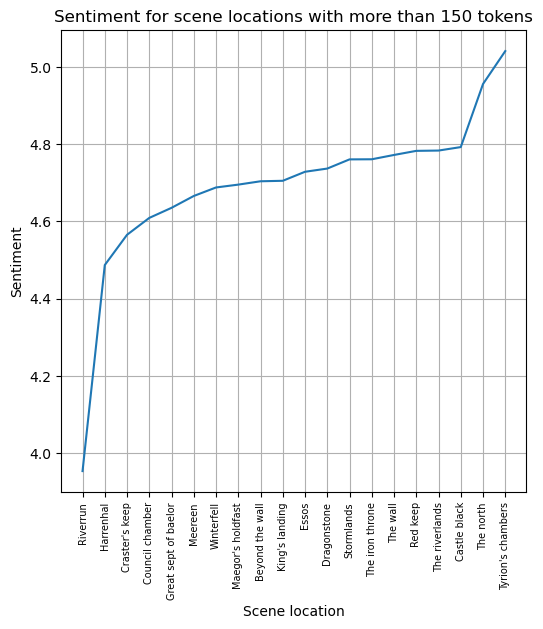

<Figure size 640x480 with 0 Axes>

In [83]:
sentimentManual = sentimentAnalysisbyGroupMT2(df["SceneLocations"], df["ScreenLine"])
dataframe = pd.DataFrame()
token_count = 250
sentlist = [sentimentManual[scene]["avg_sentiment"] for scene in sentimentManual if sentimentManual[scene]["token_count"] > token_count]
Labellist = [f'{scene[0].upper()}{scene[1:]}' if type(scene) is str else scene for scene in sentimentManual if sentimentManual[scene]["token_count"] > token_count]

dataframe["sentiment"] = sentlist
dataframe["scene"] = Labellist

dataframe = dataframe.sort_values(by='sentiment', ascending=True)
print(dataframe[dataframe["scene"] == "Tyrion's chambers"]["sentiment"])
print(dataframe[dataframe["scene"] == "Riverrun"]["sentiment"])

plt.figure(figsize=(6,6))
ax = sns.lineplot(data = dataframe, x = "scene", y = "sentiment")
plt.xlabel("Scene location")
plt.ylabel("Sentiment")
plt.xticks(rotation='vertical',size=7)
plt.title("Sentiment for scene locations with more than 150 tokens")
plt.grid()
plt.show()
plt.draw()

## Community analysis

In [28]:
# Read in the data
D = pd.read_csv('../data/scene_data.csv')
# Read in the network again
file = open('GOTNetwork.pkl', "rb")
G = pickle.load(file)
# Set a random seed for reproduciblity
np.random.seed(42)

# Define function to add the weight (the number of lines spoken) to the network
def edgeWeights_(Graph):
    edgeweights = list()
    colourList = list()
    for (FROM, TO, attributes) in Graph.edges(data=True):
        lineSum = 0
        for season,value in attributes["lines"].items():
            for episode, value2 in value.items():
                for episodename,value3 in value2.items():
                    lineSum += len(value3.keys())
        Graph[FROM][TO]["weight"] = lineSum
# apply the function
edgeWeights_(G)

To be able to compare partitions across seasons, partition the network into seasons

In [29]:
SeasonNodesList = list()
EdgeList = list()
# Partition the network into seasons 
for i in range(0,8):
    SeasonNodesList.append(set())
    EdgeList.append(list())
    for FROM, TO in G.edges():
        if i+1 in G.edges[FROM,TO]["lines"].keys():
            SeasonNodesList[i].add(FROM)
            SeasonNodesList[i].add(TO)
            EdgeList[i].append((FROM,TO))
FinalSeasonNodesList = [list(x) for x in SeasonNodesList]
EdgeSubGraphs = [G.edge_subgraph(x) for x in EdgeList]
NodeSubGraphs = [G.subgraph(x) for x in FinalSeasonNodesList]

The next step is to compare the partition of the network using the lovain community algorithm, to the partition using the houses. As some characters have several houses, a random house is added to each. This is repeated a 100 times for each season using the seed 1-100 for reproducibility. The modularity of the partitons are saved

In [30]:
# define vectors to save the output values
pl = []
pmax = []
# Repeat a 100 times
for j in range(100):
    # set the seed
    np.random.seed(j)
    pl.append([])
    pmax.append([])
    # Go through each subgraph from each season 
    for i in range(len(NodeSubGraphs)):
        # Select the correct partition
        Gsub = NodeSubGraphs[i]
        nodes = list(Gsub.nodes)
        perhos = [(per,hous) for per, hous in zip(D.Person, D.House) if per in nodes]
        
        # Make a set for each house to be able to later partition them
        per_hos = {person.lower().strip():house.split(',') for person, house in perhos if isinstance(house, str)}
        hos_per = dict()
        for person, houses in per_hos.items():
            # Select a random house
            random_house = np.random.choice(houses)
            random_house = random_house.lower().strip()
            person = person.strip().lower()
            if random_house in hos_per:
                hos_per[random_house] += [person]
            else:
                hos_per[random_house] = [person]            
        house_comm = [set(x) for x in hos_per.values()]
        
        # Remove nodes from network without a house
        Gsubsub = nx.Graph(Gsub)
        for person, house in perhos:
            if pd.isna(house):
                try:
                    Gsubsub.remove_node(person)
                except nx.NetworkXError as e:
                    pass

        # reformat the data and append the calculated modularity
        [[j for j in x] for x in house_comm]
        pl[j].append(nx.community.modularity(Gsubsub, house_comm))
        # apply the lovain community algorithm and save the output
        max_comm = nx.community.louvain_communities(Gsubsub, weight='weight')
        pmax[j].append(nx.community.modularity(Gsubsub, max_comm))

Now the same approach is repeated for the affiliations for each characters

In [31]:
# vector to save the output values
paff = []
# Repeat 100 times
for j in range(100):
    # Set seed
    np.random.seed(j)
    paff.append([])
    #Go through each season
    for i in range(len(NodeSubGraphs)):
        # select the correct partition
        Gsub = NodeSubGraphs[i]
        nodes = list(Gsub.nodes)  
        perhos = [(per,affil) for per, affil in zip(D.Person, D.Affiliations) if per in nodes]
        
        # Make a set for each affiliaton
        affil_hos = {person.lower().strip():affiliation.split(',') for person, affiliation in perhos if isinstance(affiliation, str)}
        affil_per = dict()
        for person, affiliations in affil_hos.items():
            # Select a random affiliation
            random_affiliation = np.random.choice(affiliations)
            random_affiliation = random_affiliation.lower().strip()
            person = person.strip().lower()
            if random_affiliation in affil_per:
                affil_per[random_affiliation] += [person]
            else:
                affil_per[random_affiliation] = [person]            
        affiliation_comm = [set(x) for x in affil_per.values()]
        
       # Remove nodes from the network without an affiliation 
        Gsubsub = nx.Graph(Gsub)
        for person, affiliation in perhos:
            if pd.isna(affiliation):
                try:
                    Gsubsub.remove_node(person)
                except nx.NetworkXError as e:
                    pass

        # reformat the data and append the calculated modularity
        [[j for j in x] for x in affiliation_comm]
        paff[j].append(nx.community.modularity(Gsubsub, affiliation_comm))

##### Making figure 5. Sentiment for different partitions for each season

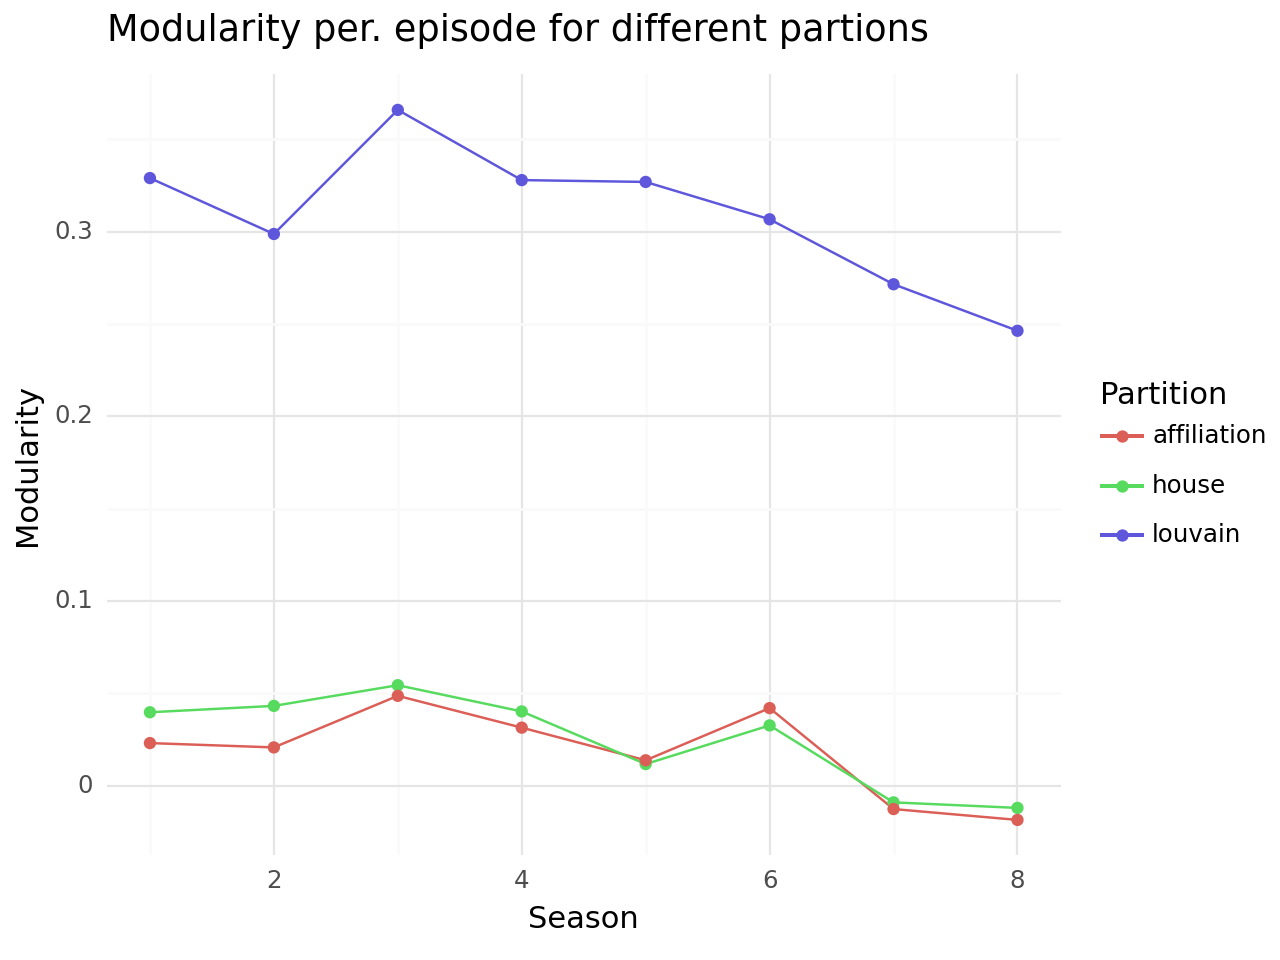

<Figure Size: (640 x 480)>

In [32]:
# calculate the mean of each repetition
x = list(np.sum(pl, axis=0)/100) + list(np.sum(paff, axis=0)/100) + list(np.sum(pmax, axis=0)/100)
# Assign the data to a dataframe
col = ['house']*8  +  ['affiliation']*8 +  ['louvain']*8 
d = pd.DataFrame()
d['data'] = x
d['type'] = col
d['123'] = list(range(1,8+1)) + list(range(1,8+1)) + list(range(1,8+1))

# Make the plot
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_minimal
(
ggplot(d, aes(y='data', x='123', color='type')) 
 + geom_line() + geom_point() + labs(x='Season', y='Modularity', color='Partition', title='Modularity per. episode for different partions')
    + theme_minimal()
)

<h1>This whole section of wordclouds and sub graphs was not used but makes for some nice visualizations</h1>

In [66]:
import wordcloud
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

TextList = ["" for i in range(8)]
TextSet = set()

# Extract the text from each edge
for i in range(1,9):
    tmpText = ""
    for _,_,att in G.edges(data=True):
        if i in att["lines"].keys():
            for episodeNr, value in att["lines"][i].items():
                for episode, value2 in value.items():
                    for scene, lines in value2.items():
                        if "".join(lines).strip() not in TextSet:
                            TextSet.add("".join(lines).strip())
                            tmpText += "".join(lines).strip()
    TextList[i-1] = nltk.word_tokenize(tmpText)

FinalTextList = list()
wnl = nltk.WordNetLemmatizer()



In [67]:
# Removing stop words and non words. NOT USED
for lists in TextList:
    tmpList = [wnl.lemmatize(x.lower()) for x in lists if re.match("\w", x) != None and x.lower() not in stopwords.words("english") and x.lower() not in ["n't","lt","lf","l","u"]]
    k = nltk.FreqDist(tmpList)
    FinalTextList.append(k)

In [68]:
#  Extracting the frequencies of the words in the dialogue. NOT USED
tftrList = list()
FreqDict = dict()
c = 8
for i in range(8):
    FreqDict = dict()
    for word, count in FinalTextList[i].items():
        weight = 0
        for k in range(len(FinalTextList)):
            if k != i:
                weight += FinalTextList[k][word]
        FreqDict[word] = count/(1/7*weight+c) # We divide the weight by seven to show what words are overrepresented in each season
    tftrList.append(FreqDict)


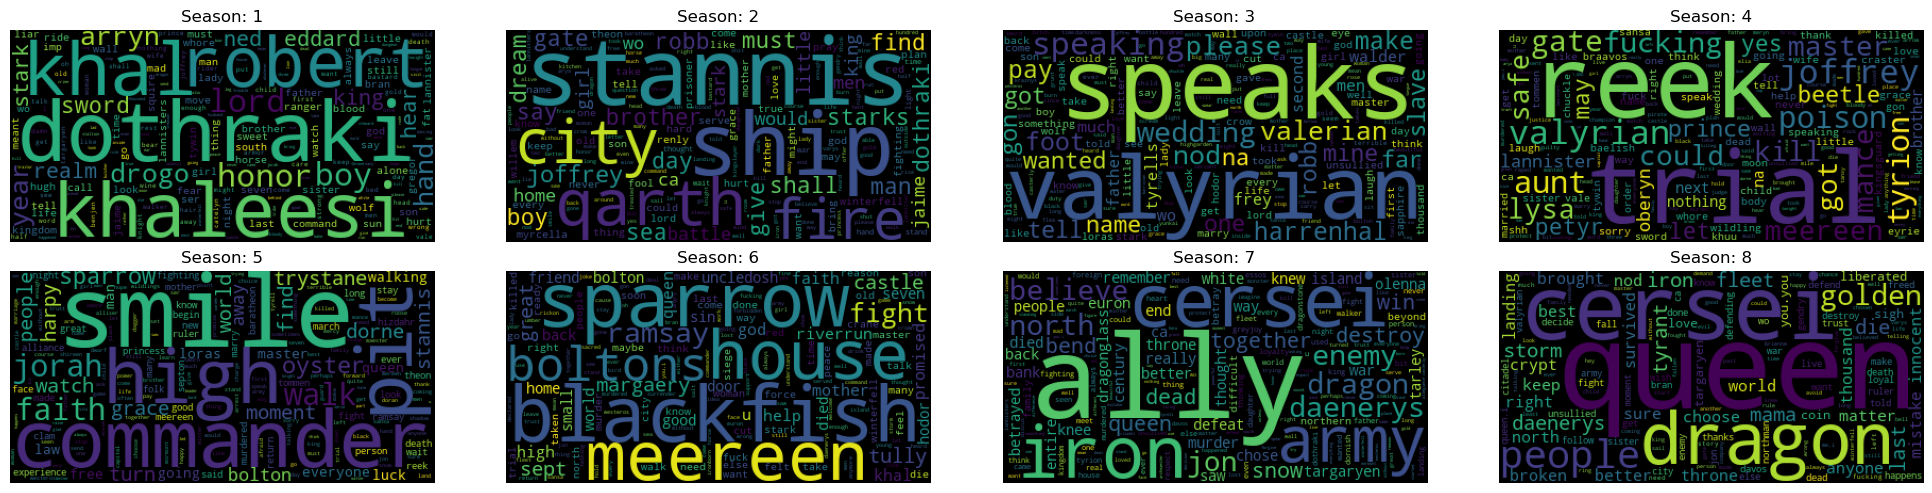

In [69]:
# Plotting the wordclouds NOT USED
plt.figure(figsize=(20,5))
for i in range(len(tftrList)):
    plt.subplot(241+i)
    WC = WordCloud(collocations=False).generate_from_frequencies(tftrList[i])
    plt.title("Season: "+ str(i+1))
    plt.imshow(WC)
    plt.axis('off')
    
plt.tight_layout() 
plt.show()

    

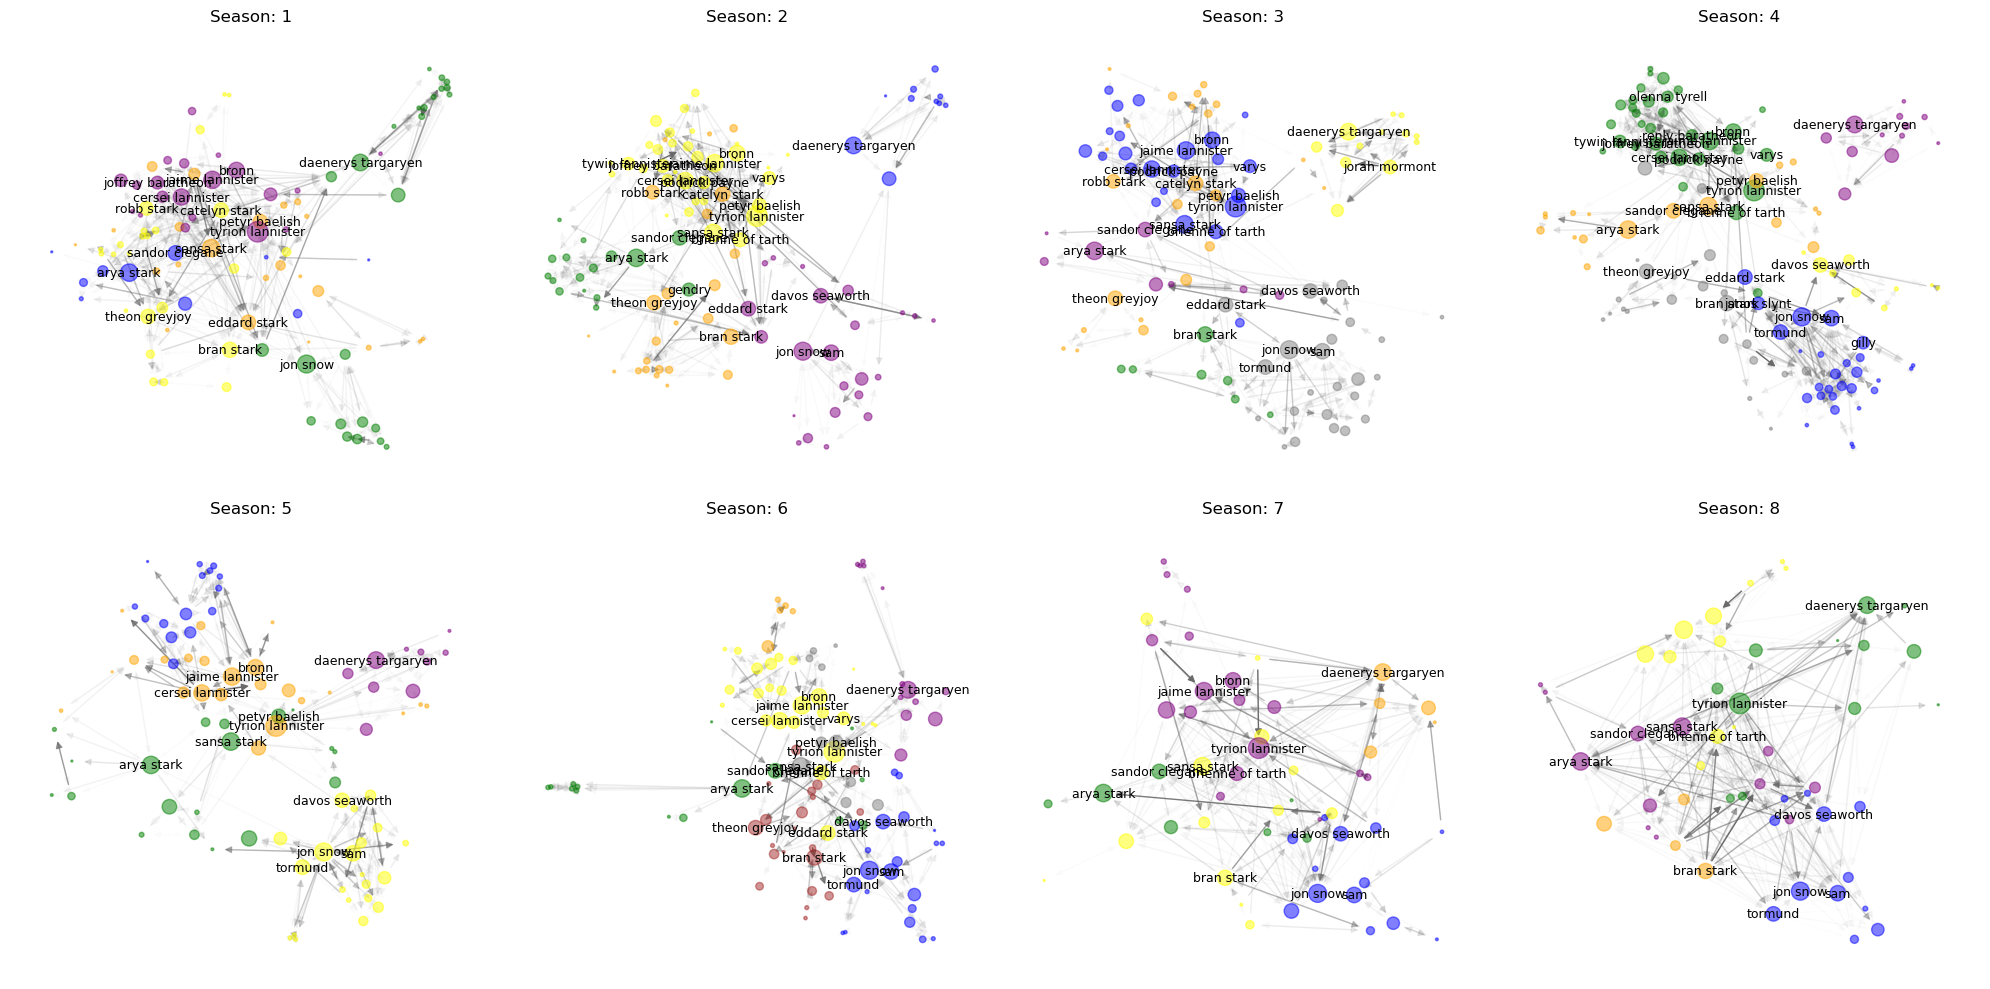

In [70]:

### Creating sub plots for each season. NOT USEED

SeasonNodesList = list()
EdgeList = list()

for i in range(0,8):
    SeasonNodesList.append(set())
    EdgeList.append(list())
    for FROM, TO in G.edges():
        if i+1 in G.edges[FROM,TO]["lines"].keys():
            SeasonNodesList[i].add(FROM)
            SeasonNodesList[i].add(TO)
            EdgeList[i].append((FROM,TO))

FinalSeasonNodesList = [list(x) for x in SeasonNodesList]
EdgeSubGraphs = [G.edge_subgraph(x) for x in EdgeList]
NodeSubGraphs = [G.subgraph(x) for x in FinalSeasonNodesList]
plt.figure(figsize=(20,10))
for i in range(len(NodeSubGraphs)):
    plt.subplot(241+i)
    PlotGrapWithComm(NodeSubGraphs[i], EdgeSubGraphs[i], 50)
    plt.title("Season: "+ str(i+1))
    
plt.tight_layout() 
plt.show()
